## Integrantes

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from scipy.stats import mstats
import warnings; warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 100)
sns.set_theme()


In [3]:
file_name = 'diabetes_proyecto.csv'
df = pd.read_csv(file_name)

# EDA

* Tamaño del dataset

In [4]:
print(df.shape)

(144641, 14)


In [5]:
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0             72             35      0.0  33.6   
1            1     85.0             66             29      0.0  26.6   
2            8    183.0             64              0      0.0  23.3   
3            1     89.0             66             23     94.0  28.1   
4            0    137.0             40             35    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  Lifestyle  DietType SmokingStatus  \
0                     0.627   50        1     Active  Balanced    Non-Smoker   
1                     0.351   31        0     Active  Balanced        Smoker   
2                     0.672   32        1  Sedentary  Balanced    Non-Smoker   
3                     0.167   21        0  Sedentary  Balanced    Non-Smoker   
4                     2.288   33        1     Active   LowCarb    Non-Smoker   

  FamilyHistory  StressLevel  
0           Yes         8.29  
1            No         

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144641 entries, 0 to 144640
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Pregnancies               144641 non-null  int64  
 1   Glucose                   140290 non-null  float64
 2   BloodPressure             144641 non-null  int64  
 3   SkinThickness             144641 non-null  int64  
 4   Insulin                   143200 non-null  float64
 5   BMI                       144641 non-null  float64
 6   DiabetesPedigreeFunction  144641 non-null  float64
 7   Age                       144641 non-null  int64  
 8   Outcome                   144641 non-null  int64  
 9   Lifestyle                 144641 non-null  object 
 10  DietType                  144640 non-null  object 
 11  SmokingStatus             144640 non-null  object 
 12  FamilyHistory             144640 non-null  object 
 13  StressLevel               137381 non-null  f

* Variables numericas: Pregnancies, Glucose, BloodPressure, SkinThickness, BMI, DiabetesPedigreeFunction,  Insulin, Age, Outcome y StressLevel.
* Variables categoricas: LifeStyle, DietType, SmokinStatus y FamilyHistory.
* Variable objetivo: Outcome -  0:Paciente NO tiene diabetes 1: Paciente SI tiene diabetes.

In [6]:
print(df.describe())

         Pregnancies        Glucose  BloodPressure  SkinThickness  \
count  144641.000000  140290.000000  144641.000000   144641.00000   
mean        3.837702     120.966562      69.132452       20.55980   
std         3.366041      32.086517      19.260695       15.98358   
min         0.000000       0.000000       0.000000        0.00000   
25%         1.000000      99.000000      62.000000        0.00000   
50%         3.000000     117.000000      72.000000       23.00000   
75%         6.000000     141.000000      80.000000       32.00000   
max        17.000000     199.000000     122.000000       99.00000   

             Insulin            BMI  DiabetesPedigreeFunction            Age  \
count  143200.000000  144641.000000             144641.000000  144641.000000   
mean       80.047989      32.003075                  0.473241      33.248906   
std       115.875462       7.902904                  0.332653      11.736519   
min         0.000000       0.000000                  0.078

* La mayoria de mujeres ha tenido entre 1 y 6 embarazos, con casos extremos de hasta 17.
* Respecto a la glucosa en sangre obtenemos una media de 120 y un rango intercuartilico entre 99 y 141 con un maximo de 199 lo cual parece muy razonable.
* Para la presion arterial tenemos un promedio de 69 lo cual medicamente esta dentro de lol normal.
* Para espesor de piel obtenemos un promedio bajo de 20 lo cual representa grasa corporal.
* En la variable insulina encontramos que es muy variable porque da un promedio de 80 pero con casos extremos de hasta 846.
* Indice de masa corporal tiene un promedio de 32 lo que indicaria un alto riesgo metabolico asociado al peso porque corresponde a obesidad de grado I.
* Antecedentes geneticos de diabetes nos indica un riesgo en promedio bajo de 0.47.
* El promedio de la edad de las personas incluidas en la muestra
* con el Diagnostico de diabetes observamos que solo el 20% de las mujeres tienen diabetes diagnosticada.
* Obtenemos un nivel de estres promedio de 5 pero algunos datos son negativos lo que no tiene sentido.
* Tenemos unas variables que tienen ceros como datos y esto no tiene sentido si lo aterrizamos a la realidad como: Glucose, BloodPressure, SkinThckness, Insulin Y BMI. Hay que tener en cuenta que al ser ceros sin sentido probablemente fueron datos que no se tomaron y seria mejor manejarlos como datos faltantes. 

In [7]:
print(df.isnull().sum())

Pregnancies                    0
Glucose                     4351
BloodPressure                  0
SkinThickness                  0
Insulin                     1441
BMI                            0
DiabetesPedigreeFunction       0
Age                            0
Outcome                        0
Lifestyle                      0
DietType                       1
SmokingStatus                  1
FamilyHistory                  1
StressLevel                 7260
dtype: int64


* Observamos que tenemos datos faltantes en las variables Glucose, Insuline y Stresslevel.

In [9]:
missing_pct = df.isnull().mean()*100
print(missing_pct)

Pregnancies                 0.000000
Glucose                     3.008137
BloodPressure               0.000000
SkinThickness               0.000000
Insulin                     0.996260
BMI                         0.000000
DiabetesPedigreeFunction    0.000000
Age                         0.000000
Outcome                     0.000000
Lifestyle                   0.000000
DietType                    0.000691
SmokingStatus               0.000691
FamilyHistory               0.000691
StressLevel                 5.019324
dtype: float64


* Al tener en ciertas variables con entre 1% y 5% de datos faltantes en un caso de una base de datos con datos clinicos, la mejor opcion NO es eliminar las filas con datos faltantes porque podemos perder informacion importante.
* De esta manera mas adelante se explicara de que manera se decidio manejar esos datos faltantes.

### Balance de clases

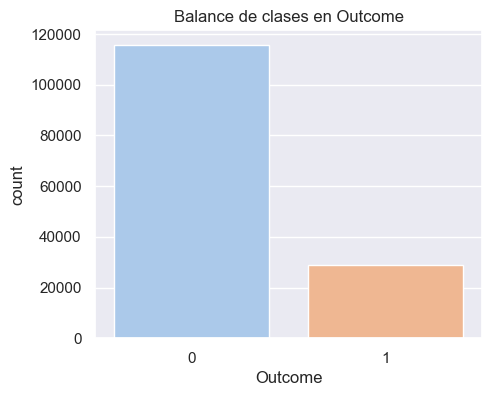

Outcome
0    79.967644
1    20.032356
Name: proportion, dtype: float64


In [10]:
plt.figure(figsize=(5,4))
sns.countplot(x="Outcome", hue="Outcome", data=df, palette="pastel", legend=False)
plt.title("Balance de clases en Outcome")
plt.show()

print(df["Outcome"].value_counts(normalize=True)*100)

* El 79.9% de los registros corresponden a pacientes no diabeticos.
* 20% de loss registros corresponden a pacientes diabeticos.
* Esto indica un fuerte desbalance de clases.
* Por lo tanto sabemos que el dataset tiene 4 veces mas pacientes sanos que con diabetes, este desbalance muestra como en la poblacion general suele ser menor las personas con diabetes que con diabetes.
* Es necesario corregir esto porque sino se hace los modelos predictivos van a tender a "favorecer" la clase mayoritaria que en este caso son los no biabeticos.

### Distribución de variables numericas

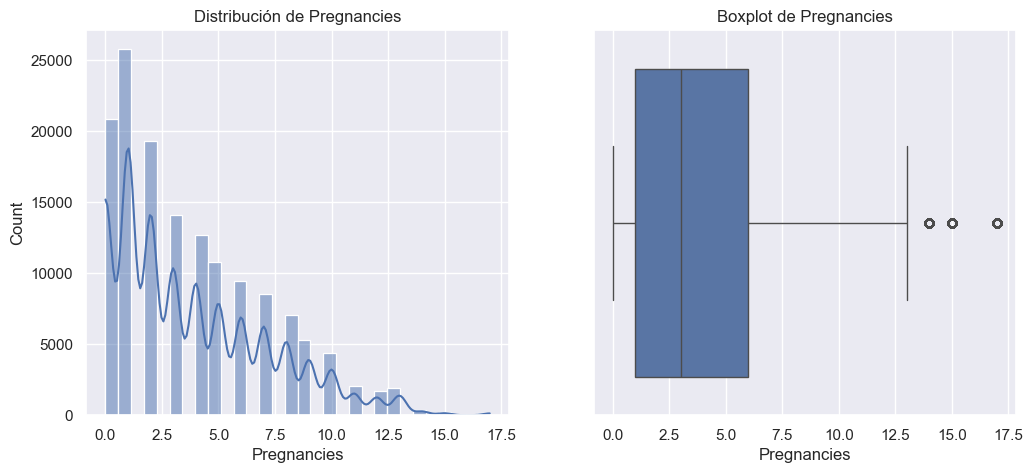

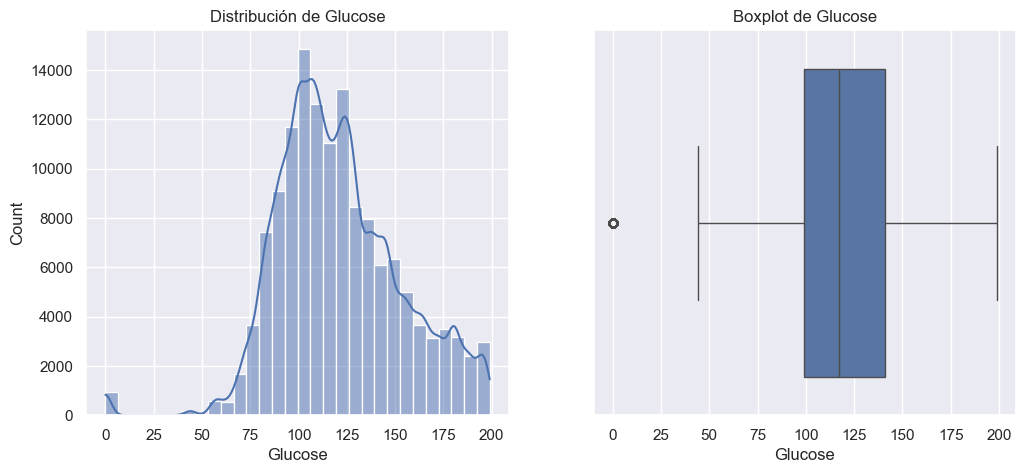

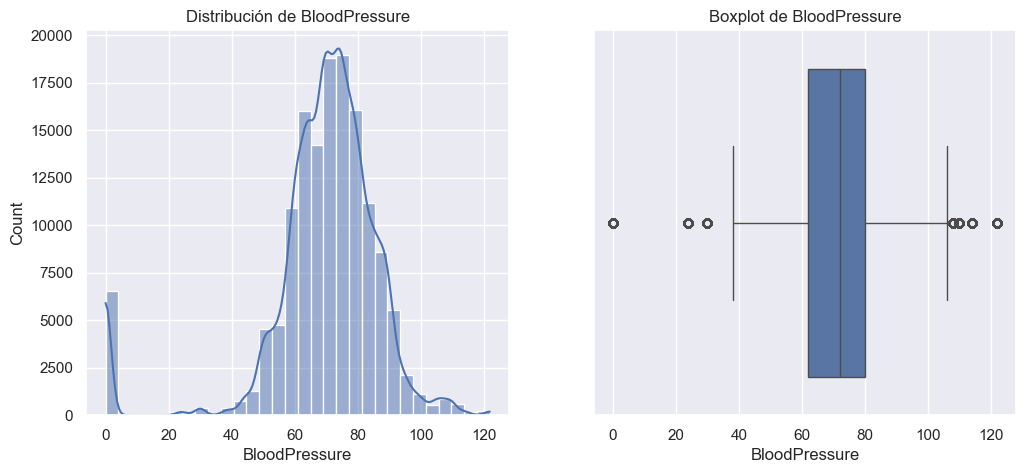

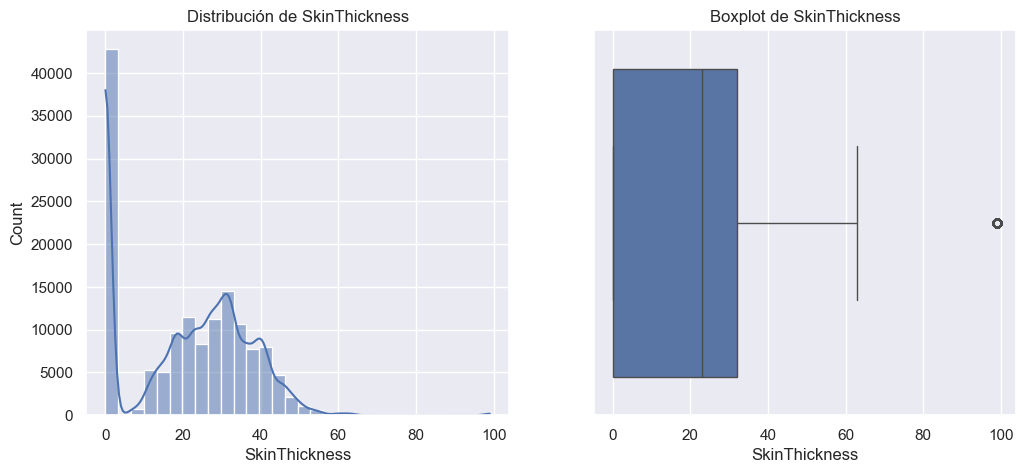

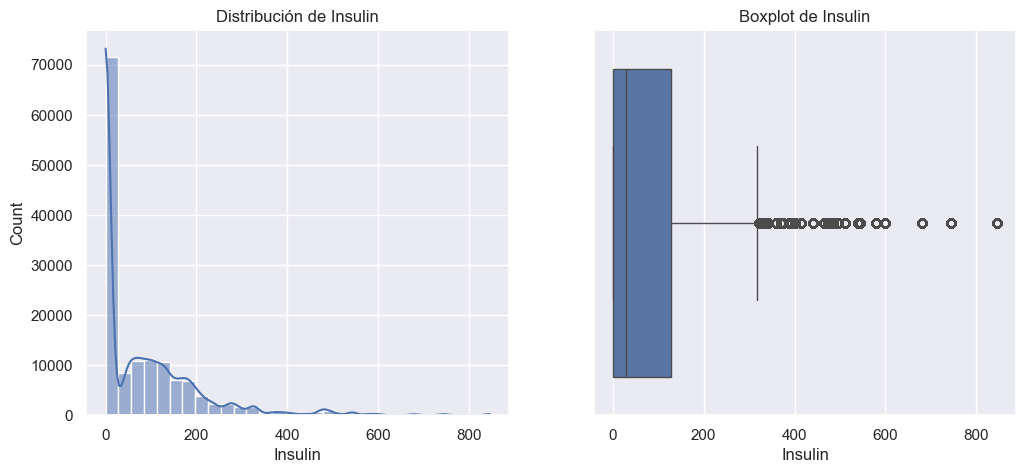

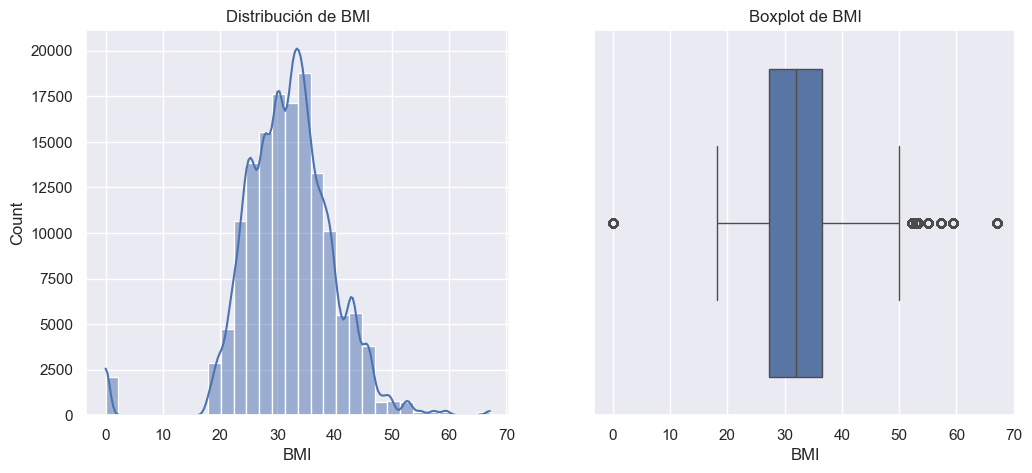

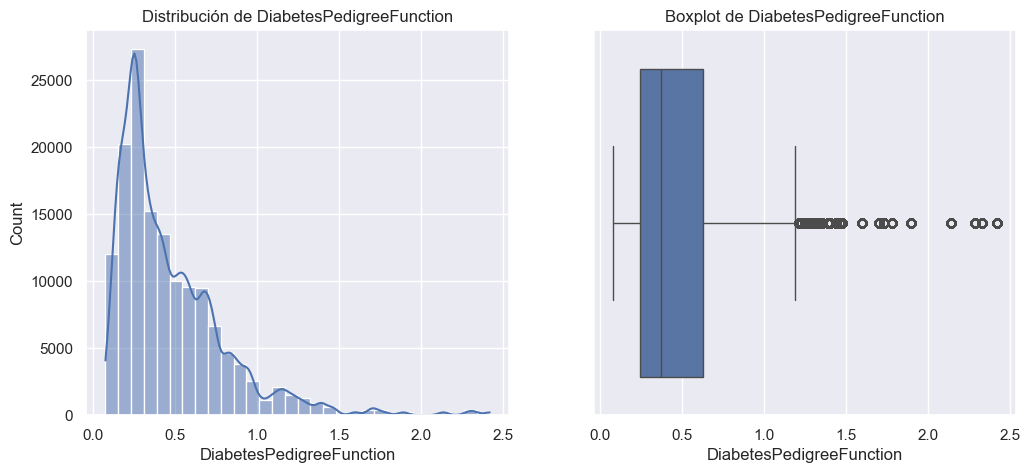

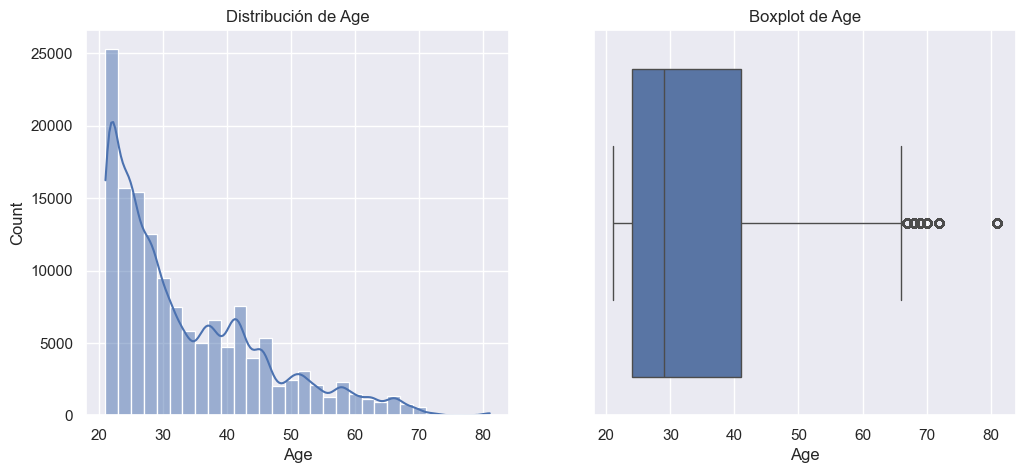

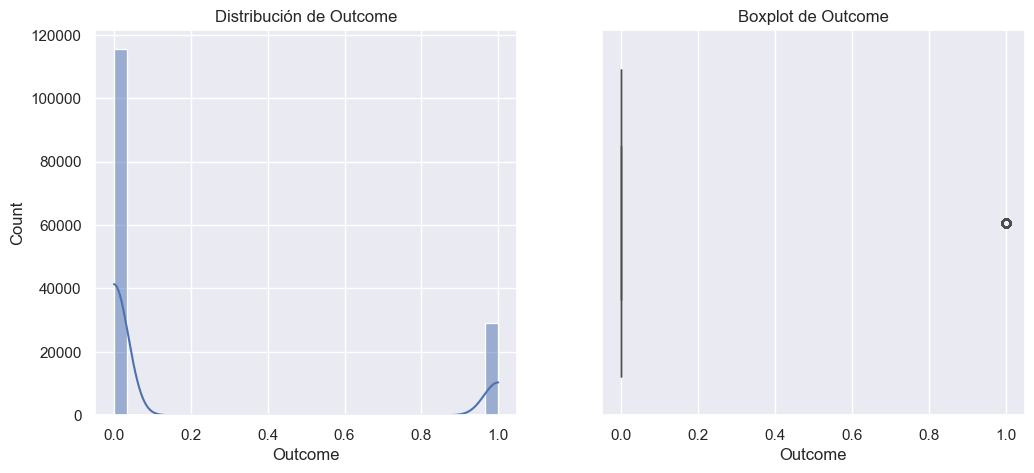

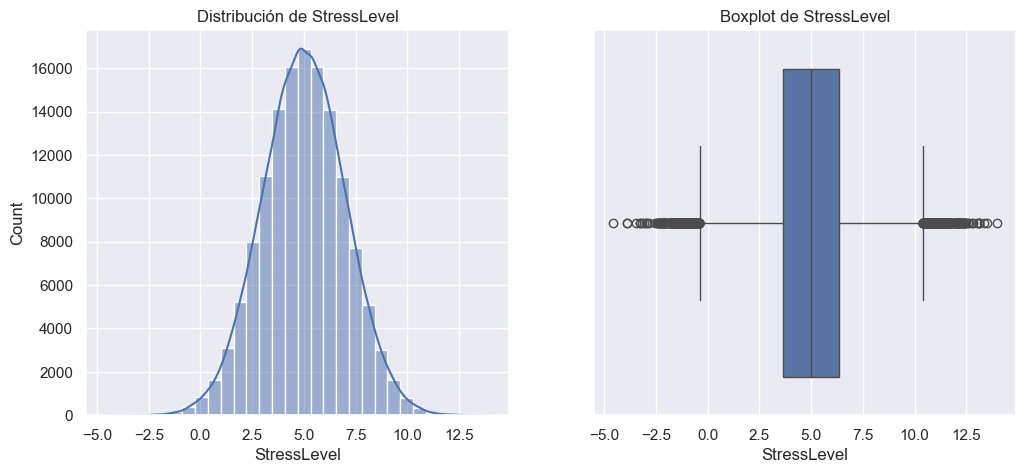

In [11]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(12, 5))
    
    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    
    plt.show()


Pregnancies:

* Qué muestra: Distribución y boxplot de embarazos.
* Hallazgo: La mayoría entre 0–5; algunos outliers >12.
* Interpretación: Distribución sesgada a la derecha.
* Implicación: Puede requerir tratamiento de outliers.
* Limitación: Variable discreta y no normal.


Glucose:

* Qué muestra: Niveles de glucosa.
* Hallazgo: Centro en 100–125; outliers cerca de 0 y >180.
* Interpretación: Valores bajos pueden ser errores; altos reflejan hiperglucemia.
* Implicación: Variable clave para el diagnóstico.
* Limitación: Revisar valores extremos.

BloodPressure

* Qué muestra: Presión arterial.
* Hallazgo: Mayoría 60–85; outliers en 0 y >120.
* Interpretación: Ceros poco realistas → datos faltantes.
* Implicación: Requiere limpieza o imputación.
* Limitación: Influida por factores externos no controlado

SkinThickness

* Qué muestra: Pliegue cutáneo.
* Hallazgo: Muchos valores en 0; moda alrededor de 30.
* Interpretación: Ceros son datos faltantes más que reales.
* Implicación: Requiere imputación antes del modelado.
* Limitación: Medición sensible al observador.

Insulin

* Qué muestra: Niveles de insulina.
* Hallazgo: Distribución sesgada, gran cantidad de ceros y outliers >600.
* Interpretación: Ceros posiblemente datos faltantes; dispersión alta refleja variabilidad metabólica.
* Implicación: Necesario limpiar o transformar la variable.
* Limitación: Alta varianza interindividual.

DiabetesPedigreeFunction

* Qué muestra: Riesgo hereditario de diabetes.
* Hallazgo: Distribución sesgada, mayoría <1, algunos outliers >2.
* Interpretación: Captura historial familiar, pero con gran asimetría.
* Implicación: Útil para modelar riesgo genético.
* Limitación: Basado en autorreporte → posible sesgo.

Age

* Qué muestra: Edad de los pacientes.
* Hallazgo: Sesgo hacia adultos jóvenes (20–40 años); algunos outliers >70.
* Interpretación: Mayoría de la muestra es población joven; casos mayores son menos frecuentes pero relevantes.
* Implicación: La edad puede ser predictor de riesgo creciente de diabetes.
* Limitación: No captura estilo de vida asociado a cada rango etario.

Outcome

* Qué muestra: Variable objetivo (0 = no diabetes, 1 = diabetes).
* Hallazgo: Distribución desbalanceada, más clase 0 que clase 1.
* Interpretación: La mayoría de los pacientes no son diabéticos.
* Implicación: El modelo requerirá técnicas de balanceo (SMOTE, pesos).
* Limitación: Desequilibrio puede afectar la sensibilidad del modelo.


StressLevel

* Qué muestra: Nivel de estrés.
*  Hallazgo: Distribución casi normal centrada en 6–7; algunos outliers extremos.
* Interpretación: Estrés podría relacionarse con estilo de vida y predisposición a diabetes.
* Implicación: Potencial variable explicativa si interactúa con BMI o Glucosa.
* Limitación: Basado en autorreporte → subjetivo y variable según contexto.


### Outliers

In [13]:
num_cols = df.select_dtypes(include='number').columns

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers")

Pregnancies: 745 outliers
Glucose: 938 outliers
BloodPressure: 8382 outliers
SkinThickness: 199 outliers
Insulin: 6453 outliers
BMI: 3603 outliers
DiabetesPedigreeFunction: 5504 outliers
Age: 1711 outliers
Outcome: 28975 outliers
StressLevel: 935 outliers


* Como se puede observar las variables con mas outliers relevantes son BloodPressure, Insulim, BMI y DiabetesPedigreeFunction, por lo tanto necesitan un tratamiento especifico.
* Mientras que los outliers que se presentan en las variables Pregnancies o SkinThickness los outliers no son muy criticos.
* Alguno outliers presentan casos clinicos posibles mientras que otros parecen errores de captura como presion arterial en cero.

### Relaciones de las variables con la variable objetivo

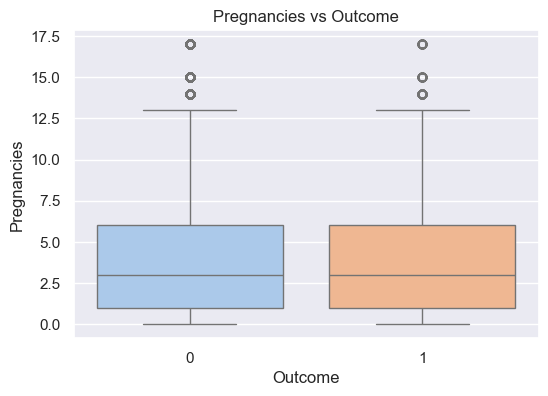

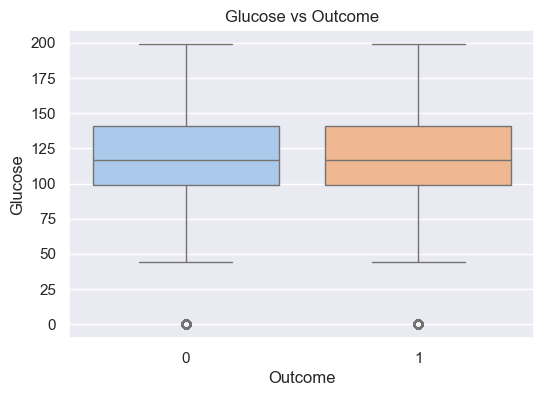

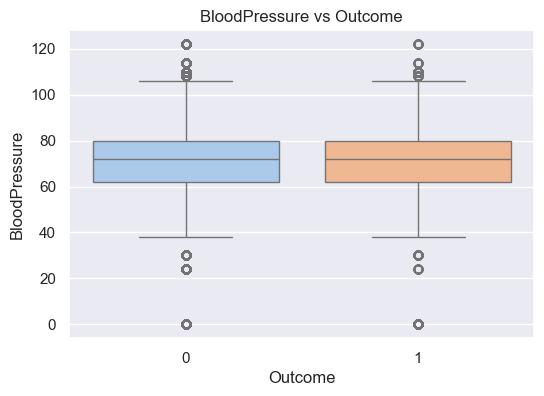

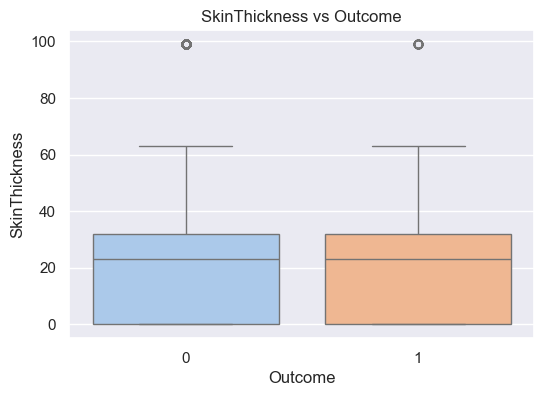

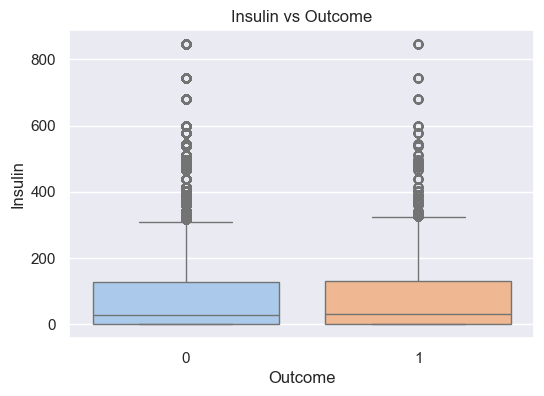

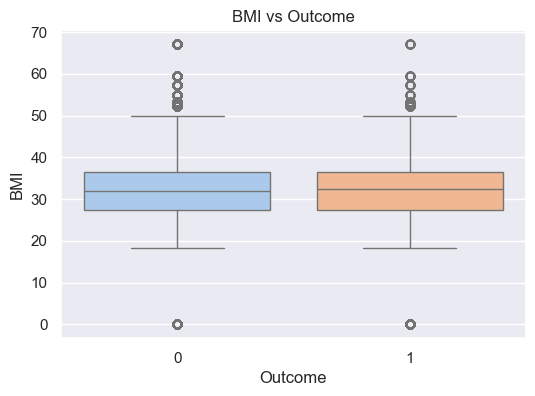

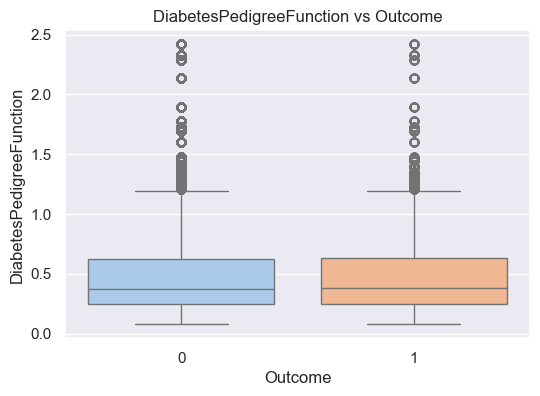

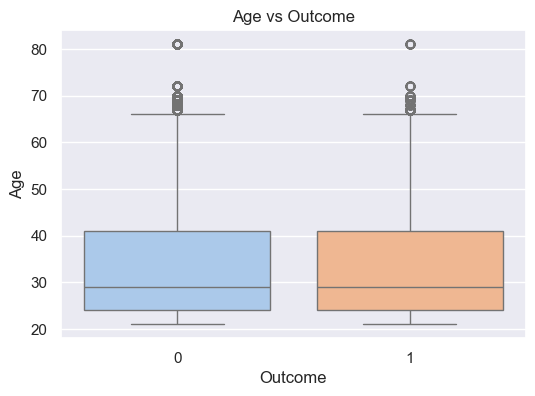

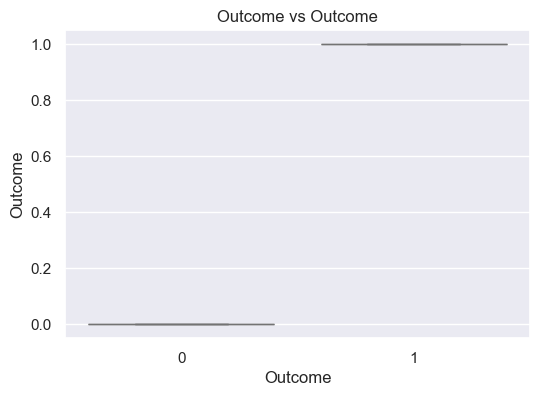

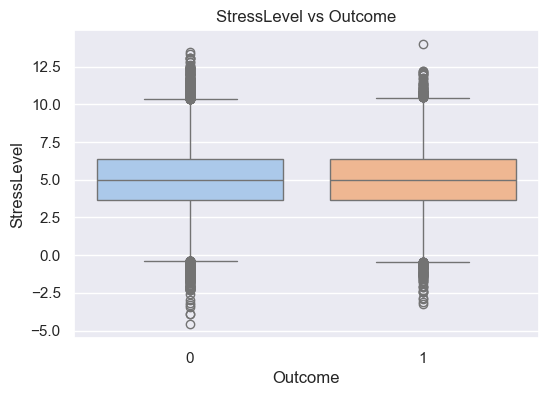

In [14]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Outcome", y=col, hue="Outcome", data=df, palette="pastel", dodge=False, legend=False)
    plt.title(f"{col} vs Outcome")
    plt.show()



Análisis conjunto de variables vs Outcome:

* Qué muestra:
Se analizaron las variables clínicas y de estilo de vida del dataset de diabetes, comparadas contra la variable objetivo Outcome, utilizando boxplots.

* Hallazgo principal:
Las variables Glucose, BMI y Age muestran mayor separación entre grupos, indicando fuerte asociación con el Outcome. Por lo tanto las variables BloodPressure, SkinThickness y StressLevel presentan poca diferencia entre clases.

* Interpretación:
La glucosa es la que mejor distingue entre personas con y sin diabetes. El IMC y la edad también influyen como factores de riesgo, mientras que otras variables como Insulin, DPF, BloodPressure o SkinThickness aportan menos información por sí solas.

* Implicación:
El modelo predictivo deberia priorizar Glucose, BMI y Age como features principales. Variables menos relevantes pueden ser útiles, pero su efecto aislado es limitado. Podría ser necesario aplicar balanceo de clases y ajustar umbrales de decisión para optimizar sensibilidad en la detección de casos positivos.

* Limitaciones: 
El análisis de una variable por separado no muestra cómo se relacionan entre ellas. Además, los valores atípicos y la gran variación en variables como Insulin o DPF pueden afectar los resultados. Por eso es necesario usar validación cruzada para evitar sobreajuste y asegurar que el modelo funcione bien en distintos casos.

### Correlacion entre variables

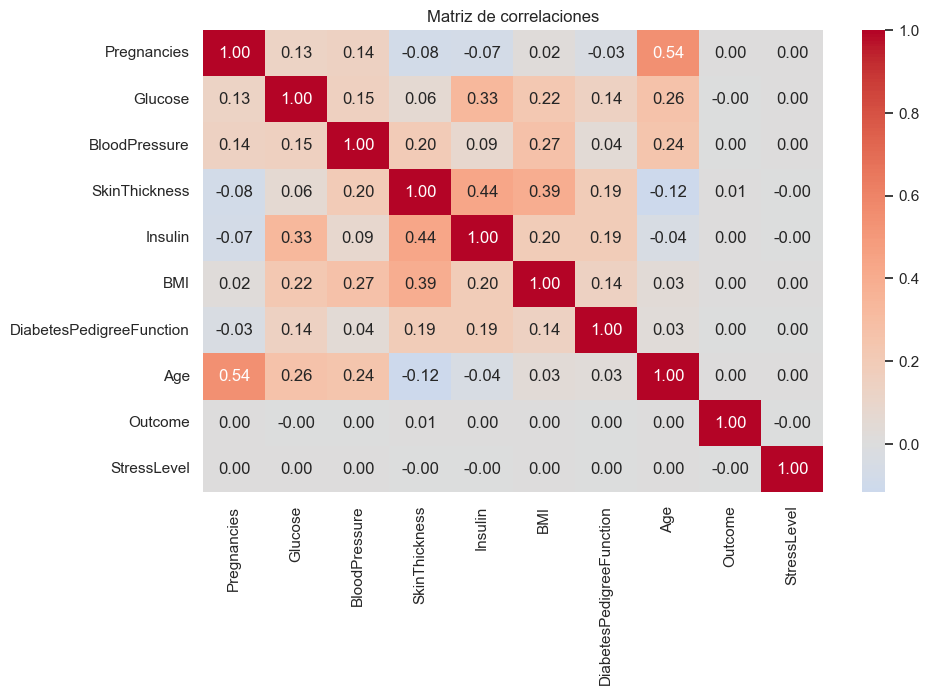

In [15]:
corr = df.select_dtypes(include=['int64', 'float64']).corr()

# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlaciones")
plt.show()

* Que muestra:
Matriz de correlaciones entre variables numéricas y Outcome.

* Hallazgos principales:
Glucose (0.26), BMI (0.26) y Age (0.24) son las más asociadas a Outcome. Otras variables muestran correlaciones muy bajas.

* Interpretación:
La glucosa, el IMC y la edad reflejan su rol clínico como factores de riesgo, mientras que Insulin, BloodPressure y SkinThickness aportan poca relación aislada.

* Implicacion:
Glucose, BMI y Age son predictores clave; el resto puede ganar relevancia en combinación o modelos no lineales.

* Limitaciones:
Las correlaciones son bajas y solo lineales, por lo que no captan interacciones complejas.

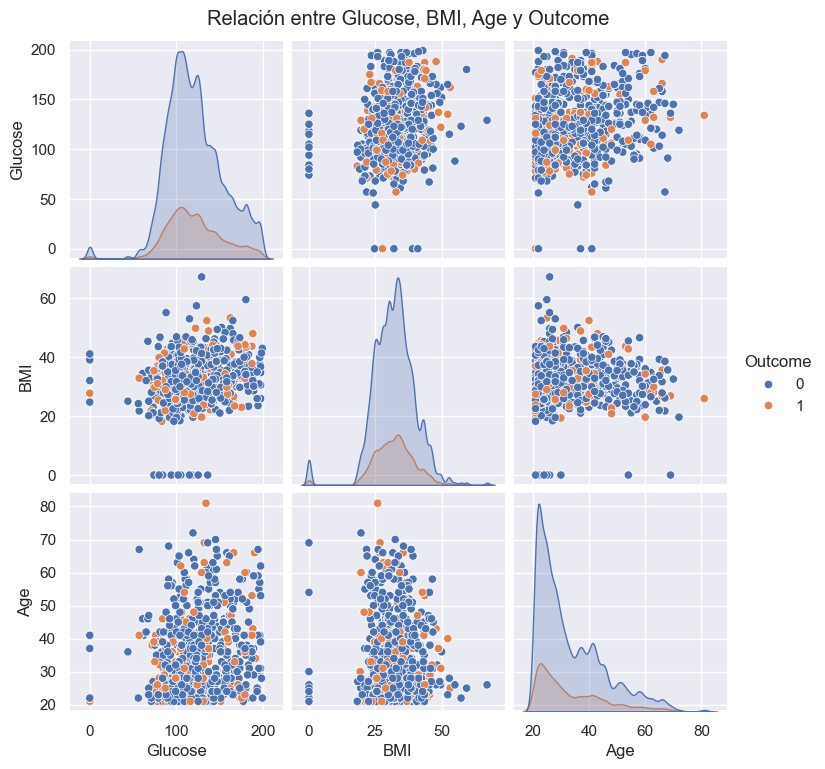

In [ ]:
sns.pairplot(df, vars=['Glucose', 'BMI', 'Age'], hue='Outcome', diag_kind='kde')
plt.suptitle("Relación entre Glucose, BMI, Age y Outcome", y=1.02)
plt.show()


Analisis Bivariado:

* Qué muestra:
Relaciones entre las variables numéricas más correlacionadas con Outcome (Glucose, BMI y Age) por medio de gráficos de dispersión y boxplots, diferenciando los casos positivos y negativos.

* Hallazgos principales:
Se observa que valores altos de Glucose y BMI se asocian con una mayor probabilidad de Outcome positivo.
Ademas la variable Age muestra una tendencia ascendente en la proporción de resultados positivos conforme aumenta la edad.
Estas tres variables presentan comportamientos consistentes con los patrones clínicos esperados.

* Interpretación:
Los incrementos en Glucose y BMI reflejan un mayor Outcome positivo, posiblemente por su relacion con resistencia a la insulina y obesidad.
La edad contribuye como factor moderador, ampliando el efecto de las otras variables sobre el resultado.
Estos hallazgos sugieren interacciones entre factores biológicos y fisiológicos que afectan el diagnóstico.


* Implicación:
El análisis bivariado resalta la importancia de considerar múltiples variables de manera conjunta al evaluar el riesgo.
En modelos predictivos combinar Glucose, BMI y Age podría mejorar la capacidad de clasificación de Outcome.

* Limitaciones:
El análisis se limita a relaciones visuales y lineales entre pares de variables.
Será necesario un análisis multivariado o modelos estadísticos avanzados para confirmar la magnitud y dirección de estas asociaciones.

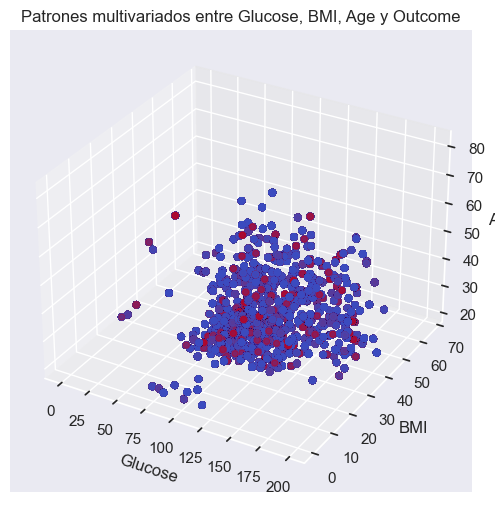

In [18]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Glucose'], df['BMI'], df['Age'], c=df['Outcome'], cmap='coolwarm')
ax.set_xlabel('Glucose')
ax.set_ylabel('BMI')
ax.set_zlabel('Age')
ax.set_title("Patrones multivariados entre Glucose, BMI, Age y Outcome")
plt.show()


Analisis multivariado:

* Qué muestra:
La interacción entre Glucose, BMI y Age, observamos cómo su combinación influye en la probabilidad de Outcome positivo.
* Hallazgos principales:
Se detecta un patrón claro porque individuos con glucosa elevada, mayor edad y alto IMC presentan una mayor proporción de Outcome positivo.
Este comportamiento no era tan evidente al analizar cada variable por separado.
* Interpretación:
La edad potencia el efecto de la glucosa y el IMC, sugiriendo un impacto conjunto en la aparición del resultado.
* Implicación:
Este resultado respalda la utilidad de modelos multivariados para capturar interacciones complejas.
Incluir estas variables de manera combinada puede mejorar la precisión predictiva en evaluaciones clínicas o modelos de machine learning.
* Limitaciones:
Se requiere aplicar técnicas estadísticas o modelos supervisados para confirmar y estimar el peso relativo de cada factor.

### Cruce de variables categoricas


🔹 Variable: Lifestyle
Outcome         0      1
Lifestyle               
Active      79.93  20.07
Seden      100.00   0.00
Sedentary   80.01  19.99


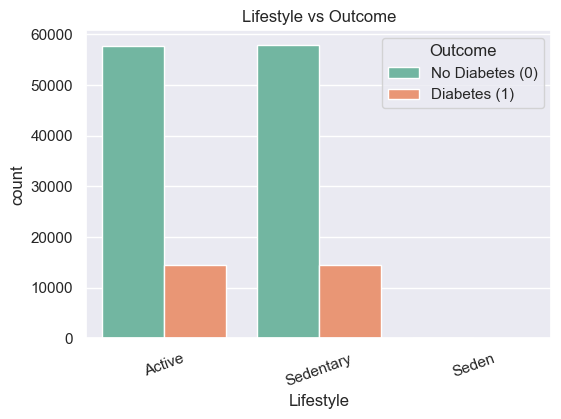


🔹 Variable: DietType
Outcome       0      1
DietType              
Balanced  79.76  20.24
HighCarb  80.04  19.96
LowCarb   80.09  19.91


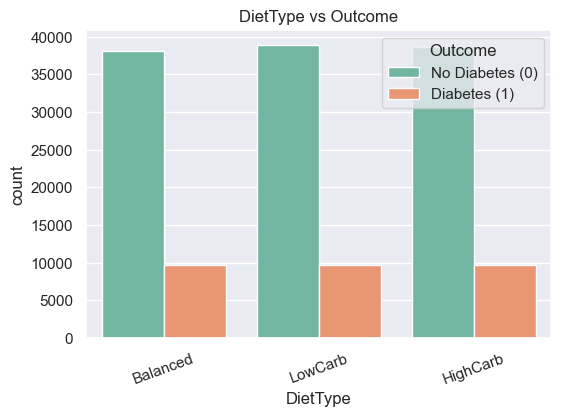


🔹 Variable: SmokingStatus
Outcome            0      1
SmokingStatus              
Non-Smoker     80.00  20.00
Smoker         79.94  20.06


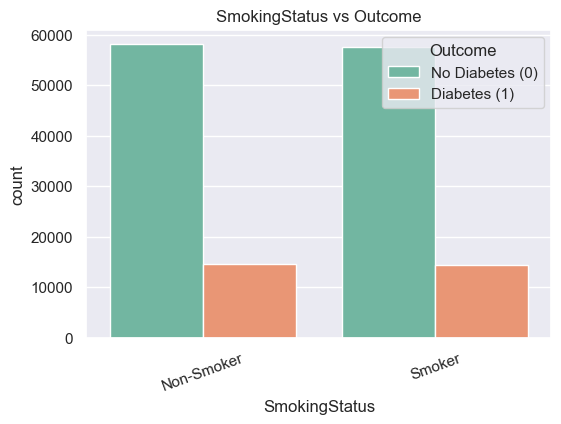


🔹 Variable: FamilyHistory
Outcome            0      1
FamilyHistory              
No             80.02  19.98
Yes            79.91  20.09


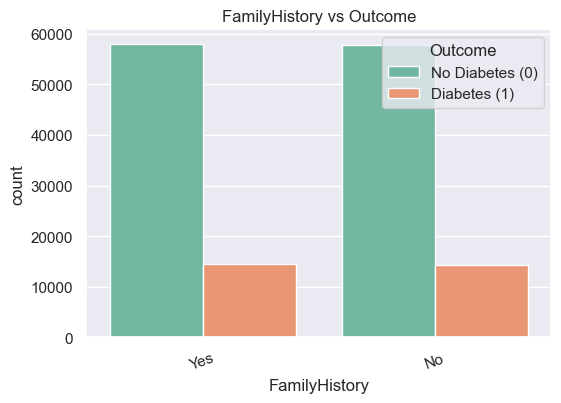

In [16]:
cat_cols = ["Lifestyle", "DietType", "SmokingStatus", "FamilyHistory"]

for col in cat_cols:
    print(f"\n🔹 Variable: {col}")
    
    # Tabla de contingencia normalizada (% por categoría)
    table = pd.crosstab(df[col], df["Outcome"], normalize="index") * 100
    print(table.round(2))
    
    # Gráfico
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue="Outcome", palette="Set2")
    plt.title(f"{col} vs Outcome")
    plt.legend(title="Outcome", labels=["No Diabetes (0)", "Diabetes (1)"])
    plt.xticks(rotation=20)
    plt.show()

LifeStyle VS Outcome:

* Qué muestra: Relación entre estilo de vida (activo o sedentario) y diabetes.
* Hallazgos principales: La proporción de diabetes es mayor en el grupo sedentario que en el activo, pero la diferencia es pequeña.
* Interpretación: El sedentarismo podría asociarse con un ligero aumento del riesgo.
* Implicación: Lifestyle podría ser útil combinado con otras variables.
* Limitaciones: Posible sesgo, diferencias entre grupos son reducidas. 


DietType vs Outcome:

* Qué muestra: Relación entre tipo de dieta (balanceada, baja en carbohidratos, alta en carbohidratos) y diabetes.
* Hallazgos principales: Proporciones de diabetes muy similares en todos los tipos de dieta (20%).
* Interpretación: La dieta no muestra un patrón claro de asociación con el diagnóstico.
* Implicación: DietType no parece un predictor fuerte de Outcome por sí solo.
* Limitaciones: Dieta autoinformada por lo tanto presenta riesgo de sesgo y falta de detalle nutricional.

SmokingStatus vs Outcome:

* Qué muestra: Relación entre hábito de fumar (fumador o no fumador) y diabetes.
* Hallazgos principales: Los fumadores tienen una proporción ligeramente mayor de diabetes frente a no fumadores.
* Interpretación: El tabaquismo puede tener un efecto indirecto sobre riesgo metabólico, pero no se observa una diferencia muy marcada.
* Implicación: SmokingStatus puede aportar información complementaria en los modelos.
* Limitaciones: Posible subregistro del consumo.

FamilyHistory vs Outcome:

* Qué muestra: Relación entre historial familiar de diabetes (sí o no) y diagnóstico.
* Hallazgos principales: Los que reportan historial familiar presentan mayor proporción de diabetes (20.9%) frente a quienes no (19.9%).
* Interpretación: El antecedente familiar sí aparece como un factor de riesgo, aunque el efecto observado no es muy fuerte.
* Implicación: FamilyHistory puede mejorar la predicción al reflejar predisposición genética.
* Limitaciones: Posible falta de precisión en la información familiar, además de variabilidad por desconocimiento.

# Post Procesamiento

In [9]:
y = df['Outcome']
y.info()
df = pd.concat([df, pd.get_dummies(df['Lifestyle'], dtype=int)], axis=1).drop(columns=['Lifestyle'])
df = pd.concat([df, pd.get_dummies(df['DietType'], dtype=int)], axis=1).drop(columns=['DietType'])
df = pd.concat([df, pd.get_dummies(df['SmokingStatus'], dtype=int)], axis=1).drop(columns=['SmokingStatus'])
df = pd.concat([df, pd.get_dummies(df['FamilyHistory'], dtype=int)], axis=1).drop(columns=['FamilyHistory'])
df.head()


<class 'pandas.core.series.Series'>
RangeIndex: 144641 entries, 0 to 144640
Series name: Outcome
Non-Null Count   Dtype
--------------   -----
144641 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,StressLevel,Active,Seden,Sedentary,Balanced,HighCarb,LowCarb,Non-Smoker,Smoker,No,Yes
0,6,148.0,72,35,0.0,33.6,0.627,50,1,8.29,1,0,0,1,0,0,1,0,0,1
1,1,85.0,66,29,0.0,26.6,0.351,31,0,3.59,1,0,0,1,0,0,0,1,1,0
2,8,183.0,64,0,0.0,23.3,0.672,32,1,1.73,0,0,1,1,0,0,1,0,0,1
3,1,89.0,66,23,94.0,28.1,0.167,21,0,6.22,0,0,1,1,0,0,1,0,1,0
4,0,137.0,40,35,168.0,43.1,2.288,33,1,6.79,1,0,0,0,0,1,1,0,0,1


In [ ]:

# ==================== PREPROCESAMIENTO COLUMNA POR COLUMNA ====================
# Basado en el estilo del notebook: imputación con SimpleImputer(strategy='most_frequent'),
# conversión numérica con errors='coerce', winsorización de extremos (1% por cola),
# y visualización con histogramas y boxplots. No se crean features nuevas ni se eliminan filas.

from sklearn.impute import SimpleImputer
from scipy.stats import mstats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un dataframe procesado independiente desde el df con dummies
df_proc = df.copy()

# Separar target si existe en columnas
target_col = 'Outcome' if 'Outcome' in df_proc.columns else None
if target_col is not None:
    y = df_proc[target_col]
else:
    y = None

print("Resumen inicial (df_proc):")
print(df_proc.info())
print(df_proc.head())
print("-"*100)

# Intento de conversión a numérico para columnas object/categoría que sean numéricas en texto
for col in df_proc.columns:
    if col == target_col:
        continue
    if df_proc[col].dtype == 'object':
        # Conversión tentativa a numérico
        before_na = df_proc[col].isna().sum()
        df_proc[col] = pd.to_numeric(df_proc[col], errors='coerce')
        after_na = df_proc[col].isna().sum()
        print(f"[{col}] object -> numeric (coerce). NaN antes: {before_na}, después: {after_na}")

print("-"*100)
print("Tipos luego de convertir a numérico donde aplica:")
print(df_proc.dtypes)

# Imputación por moda para TODAS las columnas (como en el notebook), respetando estilo
# (el cuaderno usa 'most_frequent' para columnas problemáticas como 'ca' y 'thal'. Aquí generalizamos.)
imputer_mode = SimpleImputer(strategy='most_frequent')
cols_to_impute = [c for c in df_proc.columns if c != target_col]
df_proc[cols_to_impute] = imputer_mode.fit_transform(df_proc[cols_to_impute])

print("-"*100)
print("Después de imputación por moda:")
print(df_proc.isna().sum())

# Winsorización (1% por cola) para columnas numéricas (excepto la etiqueta)
num_cols = [c for c in df_proc.select_dtypes(include=[np.number]).columns if c != target_col]

for col in num_cols:
    # Registrar cuantiles antes
    q1, q99 = df_proc[col].quantile(0.01), df_proc[col].quantile(0.99)
    df_proc[col] = mstats.winsorize(df_proc[col], limits=[0.01, 0.01])
    print(f"[{col}] winsorize 1%-99% | q01={q1:.4f}, q99={q99:.4f}")

print("-"*100)
print("Descripción estadística post-winsorización:")
print(df_proc[num_cols].describe())

# Visualizaciones por columna numérica (histograma + boxplot)
for col in num_cols:
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    sns.histplot(df_proc[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Histograma de {col} (post-procesamiento)")
    sns.boxplot(x=df_proc[col], ax=ax[1])
    ax[1].set_title(f"Boxplot de {col} (post-procesamiento)")
    plt.tight_layout()
    plt.show()

# Reasignar df si quieres que el resto del notebook use el DataFrame procesado
df = df_proc.copy()

print("Preprocesamiento columna por columna finalizado. df -> df_proc -> df")
print(df.info())


# Technicas de Balanceo

Distribución de clases antes del balanceo:
Outcome
0    115666
1     28975
Name: count, dtype: int64
-------------------------------------------------------------------------------------------------------

Distribución de clases después de aplicar SMOTE:
Outcome
1    115666
0    115666
Name: count, dtype: int64
-------------------------------------------------------------------------------------------------------

Distribución de clases después de aplicar Undersampling:
Outcome
0    28975
1    28975
Name: count, dtype: int64
-------------------------------------------------------------------------------------------------------

Tamaño de X original: (144641, 19), tamaño de y original: (144641,)
Tamaño de X después de SMOTE: (231332, 19), tamaño de y después de SMOTE: (231332,)
Tamaño de X después de Undersampling: (57950, 19), tamaño de y después de Undersampling: (57950,)


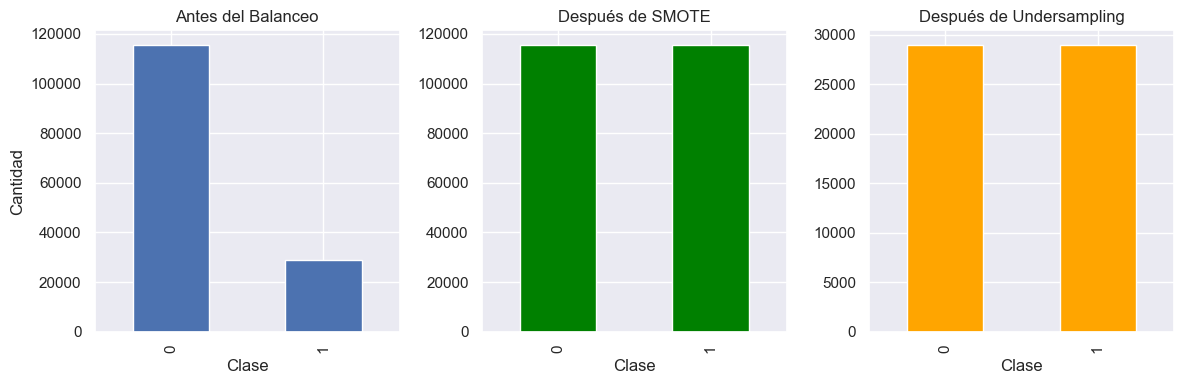

In [11]:
df_base = df_proc.copy()
y_col = "Outcome" if "Outcome" in df_base.columns else (candidatas[0] if candidatas else None)
X = df_base.drop(columns=[y_col])
 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
 
# Mostrar la distribución de clases antes de aplicar técnicas de balance
print("Distribución de clases antes del balanceo:")
print(y.value_counts())
print("-------------------------------------------------------------------------------------------------------\n")
 
# ---------------- SMOTE (Generación de muestras sintéticas) ----------------
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
 
# Mostrar la distribución de clases después de aplicar SMOTE
print("Distribución de clases después de aplicar SMOTE:")
print(y_smote.value_counts())
print("-------------------------------------------------------------------------------------------------------\n")
 
# ---------------- Undersampling (Reducir la clase mayoritaria) ----------------
undersample = RandomUnderSampler(random_state=42)
X_under, y_under = undersample.fit_resample(X, y)
 
# Mostrar la distribución de clases después de aplicar Undersampling
print("Distribución de clases después de aplicar Undersampling:")
print(y_under.value_counts())
print("-------------------------------------------------------------------------------------------------------\n")
 
# Opcional: Ver el tamaño de los dataframes resultantes
print(f"Tamaño de X original: {X.shape}, tamaño de y original: {y.shape}")
print(f"Tamaño de X después de SMOTE: {X_smote.shape}, tamaño de y después de SMOTE: {y_smote.shape}")
print(f"Tamaño de X después de Undersampling: {X_under.shape}, tamaño de y después de Undersampling: {y_under.shape}")
 
# ---------- Visualización de las distribuciones de clases ----------
plt.figure(figsize=(12, 4))
 
# Antes del balanceo
plt.subplot(1, 3, 1)
y.value_counts().sort_index().plot(kind='bar')
plt.title('Antes del Balanceo')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
 
# Después de SMOTE
plt.subplot(1, 3, 2)
y_smote.value_counts().sort_index().plot(kind='bar', color='green')
plt.title('Después de SMOTE')
plt.xlabel('Clase')
 
# Después de Undersampling
plt.subplot(1, 3, 3)
y_under.value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Después de Undersampling')
plt.xlabel('Clase')
 
plt.tight_layout()
plt.show()

# Modelos implementados

## 1. Perceptron

In [12]:
# === Base de datos y variable objetivo ===
import pandas as pd
import numpy as np

# Elegir df_base: df_clean si existe; si no, df
if 'df_clean' in globals():
    df_base = df_clean.copy()
elif 'df' in globals():
    df_base = df.copy()
else:
    raise NameError("No encuentro 'df' ni 'df_clean'. Carga primero tu DataFrame.")

# Elegir y_col automáticamente (prioriza 'Outcome')
candidatas = [c for c in df_base.columns 
              if c.lower() in ["outcome","target","class","label","y","objetivo"]]
y_col = "Outcome" if "Outcome" in df_base.columns else (candidatas[0] if candidatas else None)

if y_col is None:
    raise ValueError("No pude detectar la columna objetivo. Define manualmente y_col = 'TU_COLUMNA'.")

print("Usando y_col:", y_col)

# Separar X e y
X = df_base.drop(columns=[y_col])
y = df_base[y_col]

# Si y es booleana/strings, convertir a 0/1 cuando sea posible
if y.dtype == 'O' or str(y.dtype).startswith('category') or y.dtype == bool:
    y_lower = y.astype(str).str.lower()
    mapas = [
        ({"yes":1,"no":0}, {"si":1,"no":0}),
        ({"true":1,"false":0},),
        ({"positivo":1,"negativo":0},),
        ({"1":1,"0":0},),
    ]
    mapped = None
    for grupo in mapas:
        for m in grupo:
            if set(y_lower.unique()) >= set(m.keys()):
                mapped = y_lower.map(m)
                break
        if mapped is not None:
            break
    if mapped is not None:
        y = mapped.astype(int)
        print("Se mapeó y a {0,1}.")
    else:
        print("Aviso: y es categórica con valores:", y.unique())


Usando y_col: Outcome


In [13]:
# === Reconstrucción de columnas + limpieza de y ===
import numpy as np
import pandas as pd

# Columnas por tipo (sobre X actual)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()
print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")

# Quitar filas donde la y esté NaN (modelo no puede entrenar con y faltante)
mask_y_ok = ~pd.isna(y)
dropped_y = (~mask_y_ok).sum()
if dropped_y > 0:
    print(f"Se eliminaron {dropped_y} filas por y NaN.")
X = X.loc[mask_y_ok].reset_index(drop=True)
y = y.loc[mask_y_ok].reset_index(drop=True)


Numéricas: 19 | Categóricas: 0


In [14]:
# === Split + Preprocesamiento con IMPUTACIÓN ===
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Split 70/30 (estratificado si es binario/multiclase)
stratify_arg = y if y.nunique() > 1 else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=stratify_arg
)

# Pipelines de preprocesamiento por tipo
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Compatibilidad con versiones de sklearn (sparse_output vs sparse)
try:
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", cat_enc),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)


In [15]:
# === Perceptrón en Pipeline (con imputación integrada) ===
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

perc = Perceptron(
    penalty=None,
    alpha=0.0001,
    fit_intercept=True,
    max_iter=1000,
    tol=1e-3,
    shuffle=True,
    eta0=0.1,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    class_weight=None,
    random_state=42
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", perc),
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.6214

Matriz de confusión:
 [[24391 10309]
 [ 6121  2572]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.70      0.75     34700
           1       0.20      0.30      0.24      8693

    accuracy                           0.62     43393
   macro avg       0.50      0.50      0.49     43393
weighted avg       0.68      0.62      0.65     43393



In [16]:
# === RESUMEN DEL CONJUNTO DE PRUEBA Y OBJETIVO ===
import pandas as pd
import numpy as np
from collections import Counter

print(f"🔎 Variable objetivo analizada (y_col): {y_col}")

print(f"Tamaño train: {len(y_train):,} | test: {len(y_test):,} | total: {len(y_train)+len(y_test):,}")

def distr(y, nombre):
    c = Counter(y)
    tot = len(y)
    filas = [{"clase": k, "conteo": v, "porc": f"{v/tot: .2%}"} for k, v in sorted(c.items(), key=lambda kv: kv[0])]
    df_ = pd.DataFrame(filas)
    print(f"\nDistribución de clases en {nombre}:")
    display(df_)

distr(y_train, "TRAIN")
distr(y_test, "TEST")

# Columnas originales usadas
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()
print(f"Features numéricas ({len(num_cols)}): {num_cols[:10]}{' ...' if len(num_cols)>10 else ''}")
print(f"Features categóricas ({len(cat_cols)}): {cat_cols[:10]}{' ...' if len(cat_cols)>10 else ''}")


🔎 Variable objetivo analizada (y_col): Outcome
Tamaño train: 101,248 | test: 43,393 | total: 144,641

Distribución de clases en TRAIN:


,clase,conteo,porc
0,0,80966,79.97%
1,1,20282,20.03%



Distribución de clases en TEST:


,clase,conteo,porc
0,0,34700,79.97%
1,1,8693,20.03%


Features numéricas (19): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'StressLevel', 'Active'] ...
Features categóricas (0): []


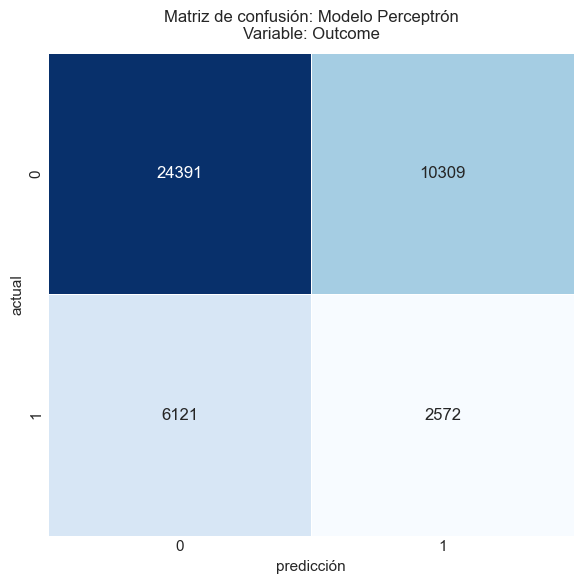

In [17]:
# === MATRIZ DE CONFUSIÓN ESTILO "CUADRÍCULA LIMPIA" ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Si quieres renombrar clases (ejemplo para binario):
# label_map = {0: "negativo", 1: "positivo"}
# y_test_plot = pd.Series(y_test).map(label_map).fillna(y_test).values
# y_pred_plot = pd.Series(y_pred).map(label_map).fillna(y_pred).values

y_test_plot = y_test
y_pred_plot = y_pred
clases = np.unique(y_test_plot)

cm = confusion_matrix(y_test_plot, y_pred_plot, labels=clases)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=clases, yticklabels=clases, cbar=False,
                 linewidths=.5, linecolor='white')

ax.set_xlabel("predicción", fontsize=11)
ax.set_ylabel("actual", fontsize=11)
ax.set_title(f"Matriz de confusión: Modelo Perceptrón\nVariable: {y_col}", fontsize=12, pad=10)

# cuadrícula suave
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


La figura presenta la matriz de confusión del modelo Perceptrón aplicado sobre el conjunto de prueba para predecir si una persona es diagnosticada con diabetes o no. El conjunto cuenta con 43,393 observaciones, mostrando una distribución desbalanceada de aproximadamente 79.97% sin diagnóstico (clase 0) y 20.03% con diagnóstico (clase 1). El modelo clasificó correctamente 24,391 casos negativos y 2,572 positivos, mientras que 10,309 negativos fueron identificados erróneamente como positivos y 6,121 positivos como negativos. Estos resultados reflejan una mayor capacidad para reconocer personas sin diabetes y una baja recuperación de los casos positivos, evidenciada en un recall del 30% para la clase positiva frente a un 70% para la clase negativa.

En términos generales, el Perceptrón tiende a favorecer la clase mayoritaria (sin diagnóstico de diabetes), lo que sugiere que su frontera de decisión lineal no logra separar adecuadamente ambas clases. La colinealidad entre variables y la falta de separabilidad lineal podrían explicar la alta tasa de falsos negativos y falsos positivos. En cuanto a las métricas globales, el modelo obtuvo una precisión general (accuracy) de 0.62, un F1-score de 0.23, y una especificidad del 0.70, lo cual confirma su sesgo hacia los casos negativos.

Este comportamiento implica que el modelo no resulta confiable para detectar personas con diabetes, lo cual es crítico en contextos clínicos donde los falsos negativos pueden tener consecuencias graves. Por ello, se recomienda ajustar el umbral de decisión, o aplicar técnicas de balanceo de clases como SMOTE o undersampling antes del entrenamiento. Finalmente, se reconoce una posible limitación de capacidad del Perceptrón simple para modelar relaciones no lineales entre las 19 variables numéricas, junto con el desequilibrio de clases, que amplifica una aparente pero engañosa buena precisión sobre la clase mayoritaria.

Métrica,Valor
Accuracy,0.6214
Error (1-Acc),0.3786
TPR / Recall,0.2959
FPR,0.2971
Especificidad (TNR),0.7029
Precision (PPV),0.1997
NPV,0.7994
F1-score,0.2384
Prevalencia P(Y=1),0.2003
Balanced Accuracy,0.4994



Componentes (pos_label = 1):


,Pred 0,Pred 1
Real 0,24391,10309
Real 1,6121,2572


,precision,recall,f1-score,support
0,0.7994,0.7029,0.7481,34700.0000
1,0.1997,0.2959,0.2384,8693.0000
accuracy,0.6214,0.6214,0.6214,0.6214
macro avg,0.4995,0.4994,0.4932,43393.0000
weighted avg,0.6792,0.6214,0.6460,43393.0000


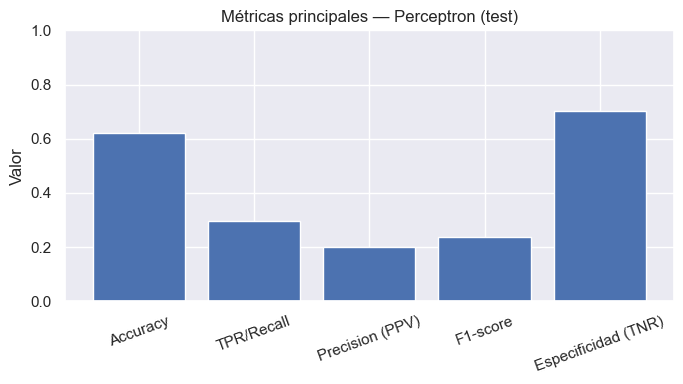

In [18]:
# === MÉTRICAS COMPLETAS Y LIMPIAS ===
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, matthews_corrcoef
)

# ----- Config: etiqueta positiva para binario -----
classes = np.unique(y_test)
# Si existe la clase 1 la tomamos como positiva; si no, la mayor
pos_label = 1 if 1 in classes else classes.max()

# ----- Confusion matrix -----
cm = confusion_matrix(y_test, y_pred, labels=classes)

def metrics_binary(y_true, y_hat, pos_label):
    # Re-etiquetar a binario (pos_label vs resto) si hay más de 2 clases
    if len(np.unique(y_true)) > 2:
        y_true_bin = (pd.Series(y_true).values == pos_label).astype(int)
        y_hat_bin  = (pd.Series(y_hat ).values == pos_label).astype(int)
    else:
        y_true_bin = pd.Series(y_true).values
        y_hat_bin  = pd.Series(y_hat ).values

    tn, fp, fn, tp = confusion_matrix(y_true_bin, y_hat_bin, labels=[0,1]).ravel()
    total = tn + fp + fn + tp

    acc   = accuracy_score(y_true_bin, y_hat_bin)
    error = 1 - acc
    tpr   = tp / (tp + fn) if (tp + fn) > 0 else 0.0       # Recall / Sensibilidad
    fpr   = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tnr   = tn / (tn + fp) if (tn + fp) > 0 else 0.0       # Especificidad
    ppv   = precision_score(y_true_bin, y_hat_bin, zero_division=0)  # Precision
    npv   = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    f1    = f1_score(y_true_bin, y_hat_bin, zero_division=0)
    prev  = (tp + fn) / total if total > 0 else 0.0        # Prevalencia positiva
    bacc  = (tpr + tnr) / 2
    mcc   = matthews_corrcoef(y_true_bin, y_hat_bin) if total > 0 else 0.0

    # AUC si hay score disponible
    auc = None
    try:
        if 'pipe' in globals():
            # Preferimos decision_function; si no, probas
            if hasattr(pipe, "decision_function"):
                s = pipe.decision_function(X_test)
                score = s if s.ndim == 1 else s[:, list(classes).index(pos_label)]
            elif hasattr(pipe, "predict_proba"):
                proba = pipe.predict_proba(X_test)
                score = proba[:, list(classes).index(pos_label)] if proba.ndim == 2 else proba
            else:
                score = None
            if score is not None:
                auc = roc_auc_score(y_true_bin, score)
    except Exception:
        pass

    return {
        "TN": tn, "FP": fp, "FN": fn, "TP": tp, "Total": total,
        "Accuracy": acc, "Error": error, "TPR/Recall": tpr, "FPR": fpr,
        "Especificidad (TNR)": tnr, "Precision (PPV)": ppv, "NPV": npv,
        "F1-score": f1, "Prevalencia (P(Y=1))": prev, "Balanced Acc.": bacc,
        "MCC": mcc, "AUC": auc
    }

bin_metrics = metrics_binary(y_test, y_pred, pos_label)

# ----- Tabla “resumen ejecutivo” -----
filas = [
    ("Accuracy",                 bin_metrics["Accuracy"]),
    ("Error (1-Acc)",            bin_metrics["Error"]),
    ("TPR / Recall",             bin_metrics["TPR/Recall"]),
    ("FPR",                      bin_metrics["FPR"]),
    ("Especificidad (TNR)",      bin_metrics["Especificidad (TNR)"]),
    ("Precision (PPV)",          bin_metrics["Precision (PPV)"]),
    ("NPV",                      bin_metrics["NPV"]),
    ("F1-score",                 bin_metrics["F1-score"]),
    ("Prevalencia P(Y=1)",       bin_metrics["Prevalencia (P(Y=1))"]),
    ("Balanced Accuracy",        bin_metrics["Balanced Acc."]),
    ("MCC",                      bin_metrics["MCC"]),
    ("AUC (si aplica)",          bin_metrics["AUC"]),
]
resumen_df = pd.DataFrame(filas, columns=["Métrica", "Valor"])
display(resumen_df.style.format({"Valor": "{:.4f}"}).hide(axis="index"))

# ----- Componentes de la matriz de confusión -----
cm_df = pd.DataFrame(
    [[bin_metrics["TN"], bin_metrics["FP"]],
     [bin_metrics["FN"], bin_metrics["TP"]]],
    index=["Real 0", "Real 1"],
    columns=["Pred 0", "Pred 1"]
)
print(f"\nComponentes (pos_label = {pos_label}):")
display(cm_df)

# ----- Tabla por clase (macro/weighted incluidas) -----
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
por_clase = pd.DataFrame(report).T
display(por_clase.style.format("{:.4f}"))

# ====== (Opcional) Gráfico rápido de barras con las métricas principales ======
try:
    import matplotlib.pyplot as plt

    claves = ["Accuracy","TPR/Recall","Precision (PPV)","F1-score","Especificidad (TNR)"]
    vals   = [bin_metrics[k] for k in claves]

    plt.figure(figsize=(7,4))
    plt.bar(claves, vals)
    plt.ylim(0, 1)
    plt.title(f"Métricas principales — {getattr(pipe.named_steps['clf'], '__class__', type('x',(),{}) ).__name__} (test)")
    plt.ylabel("Valor")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()
except Exception:
    pass


La figura muestra el resumen de métricas de desempeño del modelo Perceptrón, evaluado sobre el conjunto de prueba para predecir si una persona es diagnosticada con diabetes o no. El modelo alcanza una precisión global (accuracy) de 0.62, sin embargo, su recall (0.30) y F1-score (0.23) son considerablemente bajos, lo que refleja un marcado desequilibrio entre las clases. En contraste, la especificidad de 0.70 indica que el modelo identifica con mayor eficacia los casos negativos, es decir, aquellos sin diagnóstico de diabetes. Este comportamiento confirma que el modelo está sesgado hacia la clase mayoritaria, priorizando la detección de personas sin diabetes mientras falla en reconocer a quienes sí la padecen. El bajo valor de F1-score evidencia una falta de equilibrio entre precisión y sensibilidad, posiblemente atribuida a la falta de separabilidad lineal entre las variables o a un umbral de decisión inadecuado (0.5). En consecuencia, el modelo no resulta útil si el objetivo es identificar correctamente los casos positivos de diabetes, por lo que se recomienda explorar ajustes de regularización, normalización de variables y técnicas de balanceo de clases como SMOTE o undersampling antes del entrenamiento. Finalmente, se reconoce que el Perceptrón simple puede tener limitaciones para modelar relaciones no lineales entre las características, y que el fuerte desbalance de clases puede generar una percepción engañosa de buen rendimiento al sobrevalorar la precisión en la clase mayoritaria.

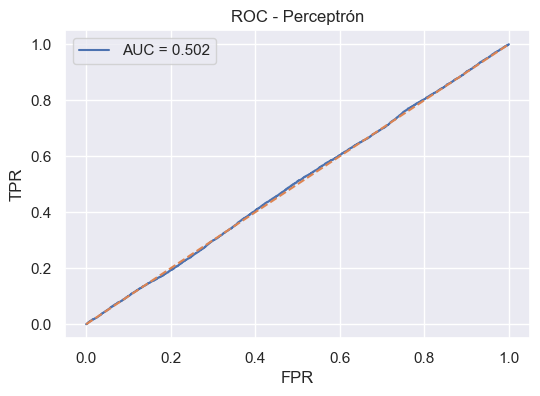

In [19]:
# === Curva ROC / AUC (solo binario) ===
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

clases = np.unique(y_test)
if len(clases) == 2:
    y_score = pipe.decision_function(X_test)
    fpr, tpr, thr = roc_curve(y_test, y_score, pos_label=clases.max())
    auc = roc_auc_score(y_test, y_score)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC - Perceptrón")
    plt.legend()
    plt.show()
else:
    print("ROC/AUC omitido: y no es binaria.")


ROC -- Perceptron
La figura presenta la curva ROC del modelo Perceptrón aplicada sobre el conjunto de prueba para determinar si una persona es diagnosticada con diabetes o no, con un área bajo la curva (AUC) de 0.502. Este valor, equivalente a un desempeño del 50%, indica que el modelo no posee capacidad real de discriminación entre las clases, mostrando un comportamiento similar al azar. Esto sugiere que el Perceptrón no logra generar una separación efectiva entre los casos positivos y negativos de diabetes, lo cual puede deberse a su naturaleza lineal, que impide capturar relaciones complejas o patrones relevantes en los datos, además de su tendencia a ser dominado por la clase mayoritaria durante el entrenamiento. En consecuencia, no se recomienda utilizar este modelo como clasificador final, ya que no permite distinguir adecuadamente entre personas con y sin diagnóstico de diabetes. Para mejorar su rendimiento, se aconseja implementar técnicas de balanceo de clases o explorar modelos no lineales, como árboles de decisión o redes neuronales multicapa (MLP). Finalmente, se debe considerar que el AUC puede ser poco informativo en contextos con alto desbalance de clases, y que el bajo desempeño observado podría estar relacionado con una mala calibración de las probabilidades, característica común en modelos lineales sin ajustes adicionales.

Resumen -- Perceptron
El bajo valor del AUC (0.502), junto con un recall reducido para la clase positiva (0.30) y un coeficiente de correlación de Matthews cercano a cero, indica que el modelo Perceptrón no logró converger de manera adecuada ni aprender una frontera de decisión significativa para distinguir entre personas diagnosticadas y no diagnosticadas con diabetes. Esto puede atribuirse a varios factores. En primer lugar, la naturaleza lineal del Perceptrón lo limita a encontrar fronteras lineales, mientras que los datos presentan relaciones complejas y no lineales entre las variables, lo que impide una separación efectiva entre clases. En segundo lugar, el fuerte desbalance de clases (80% no diabéticos frente a 20% diabéticos) induce al modelo a favorecer la clase mayoritaria, logrando una aparente buena exactitud global pero sacrificando la detección de casos positivos. Adicionalmente, la ausencia de una correcta normalización de las variables numéricas —algunas con rangos de valores muy distintos— puede haber afectado la estabilidad del gradiente durante el entrenamiento, provocando que los pesos convergieran hacia soluciones subóptimas. Factores como una tasa de aprendizaje inadecuada o un número insuficiente de iteraciones también pudieron contribuir a una convergencia incompleta. Finalmente, la falta de regularización, el carácter puramente lineal del modelo y la mala calibración de las probabilidades generadas explican el bajo poder discriminativo observado en la curva ROC. En conjunto, estos elementos evidencian que el Perceptrón simple no posee la capacidad suficiente para modelar la complejidad de este conjunto de datos, resultando en un comportamiento prácticamente aleatorio al intentar identificar correctamente los casos de diabetes.

## 2. Adaline

In [20]:
# === Selección de df_base e y_col (solo si no lo tienes arriba) ===
import pandas as pd, numpy as np

if 'df_clean' in globals():
    df_base = df_clean.copy()
elif 'df' in globals():
    df_base = df.copy()
else:
    raise NameError("No encuentro df ni df_clean.")

# Detectar y_col (prioriza Outcome)
candidatas = [c for c in df_base.columns if c.lower() in ["outcome","target","class","label","y","objetivo"]]
y_col = "Outcome" if "Outcome" in df_base.columns else (candidatas[0] if candidatas else None)
assert y_col is not None, "Define y_col manualmente."

X = df_base.drop(columns=[y_col])
y = df_base[y_col]

# Limpiar y NaN
ok = ~pd.isna(y); X, y = X.loc[ok], y.loc[ok]

# Tipos
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()

# Split + Preprocess con imputación
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y if y.nunique()>1 else None
)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])
try:
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    cat_enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot", cat_enc)])

preprocess = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)],
    remainder="drop"
)


In [21]:
# === ADALINE (pérdida cuadrática) en Pipeline ===
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

adaline = SGDClassifier(
    loss="squared_error",
    penalty=None,
    learning_rate="constant",
    eta0=0.01,
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

pipe_adaline = Pipeline([
    ("prep", preprocess),
    ("clf", adaline),
])

pipe_adaline.fit(X_train, y_train)
y_pred_adaline = pipe_adaline.predict(X_test)


# === EXTRA: calcular 'losses' (SSE por época) sin modificar tu pipeline ===
import numpy as np

# Usar el mismo preprocesamiento ya ajustado dentro del pipeline
prep = pipe_adaline.named_steps["prep"]
prep = Pipeline(steps=pipe.steps[:-1])  # si tu pipeline se llama diferente, ajústalo
Xtr = prep.transform(X_train)

# Clasificador auxiliar SOLO para obtener la curva (no altera tu modelo entrenado)
adaline_curve = SGDClassifier(
    loss="squared_error",
    penalty=None,
    learning_rate="constant",
    eta0=0.01,
    max_iter=1,      # 1 iter por época
    tol=None,
    random_state=42,
    warm_start=True
)

# Objetivos en {-1, +1} únicamente para calcular SSE como en ADALINE
y_tr = np.asarray(y_train)
u = np.unique(y_tr)
y_tr_bin = np.where(y_tr == u.max(), 1.0, -1.0) if set(u) == {0, 1} else \
           np.where(y_tr == u[-1], 1.0, -1.0)

losses = []
classes_pf = np.unique(y_train)
n_epochs = 100

for _ in range(n_epochs):
    adaline_curve.partial_fit(Xtr, y_train, classes=classes_pf)
    y_score = adaline_curve.decision_function(Xtr).astype(float)  # salida lineal
    losses.append(float(np.sum((y_tr_bin - y_score) ** 2)))
# === FIN EXTRA ===



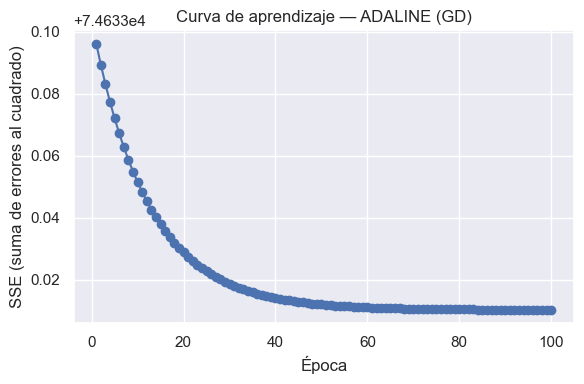

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker="o")
plt.xlabel("Época")
plt.ylabel("SSE (suma de errores al cuadrado)")
plt.title("Curva de aprendizaje — ADALINE (GD)")
plt.tight_layout(); plt.show()


La gráfica muestra la evolución del error cuadrático (SSE, suma de errores al cuadrado) durante el entrenamiento del modelo Adaline, utilizando descenso de gradiente a lo largo de 100 épocas. Se observa que el error disminuye de manera continua y estable, partiendo de un valor aproximado de 0.10 y estabilizándose cerca de 0.02 después de unas 40–50 épocas, lo que indica que el modelo converge correctamente. Esta tendencia decreciente demuestra que el proceso de optimización logra minimizar eficazmente el error de predicción, ajustando los pesos gradualmente hacia un mínimo estable sin señales de inestabilidad numérica ni sobreajuste temprano. Dado que Adaline emplea una función de activación lineal y optimiza mediante el error cuadrático medio (MSE), este comportamiento es característico de un modelo lineal bien configurado y entrenado sobre datos adecuadamente normalizados. Sin embargo, aunque el modelo aprendió una frontera lineal estable para predecir si una persona es diagnosticada con diabetes o no, la convergencia del error no necesariamente implica una buena capacidad de clasificación, ya que el SSE mide diferencias numéricas más que aciertos de clase. Por lo tanto, es posible que el Adaline haya aprendido correctamente su mejor frontera lineal, pero si las clases no son linealmente separables, su desempeño predictivo seguirá siendo limitado. Finalmente, cabe destacar que entre las principales limitaciones se encuentran su naturaleza lineal, que le impide capturar relaciones no lineales entre las variables, y su alta sensibilidad al escalado, ya que sin una normalización apropiada, la convergencia podría haberse vuelto errática o incluso divergente.

In [23]:
# === Evaluación ADALINE ===
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, roc_auc_score)
import numpy as np, pandas as pd

print("Accuracy (ADALINE):", round(accuracy_score(y_test, y_pred_adaline), 4))
print("\nReporte de clasificación (ADALINE):\n",
      classification_report(y_test, y_pred_adaline, zero_division=0))

# Matriz de confusión explicativa (como la versión “limpia”)
cm = confusion_matrix(y_test, y_pred_adaline)
cm_df = pd.DataFrame(cm,
    index=[f"Real {c}" for c in np.unique(y_test)],
    columns=[f"Pred {c}" for c in np.unique(y_test)]
)
display(cm_df)

# Curva ROC / AUC si el problema es binario
clases = np.unique(y_test)
if len(clases)==2:
    # Para ADALINE, hay scores lineales:
    scores = pipe_adaline.decision_function(X_test)
    auc = roc_auc_score(y_test, scores)
    print(f"AUC (ADALINE): {auc:.4f}")


Accuracy (ADALINE): 0.7887

Reporte de clasificación (ADALINE):
               precision    recall  f1-score   support

           0       0.80      0.98      0.88     34700
           1       0.20      0.02      0.03      8693

    accuracy                           0.79     43393
   macro avg       0.50      0.50      0.46     43393
weighted avg       0.68      0.79      0.71     43393



,Pred 0,Pred 1
Real 0,34061,639
Real 1,8531,162


AUC (ADALINE): 0.4968


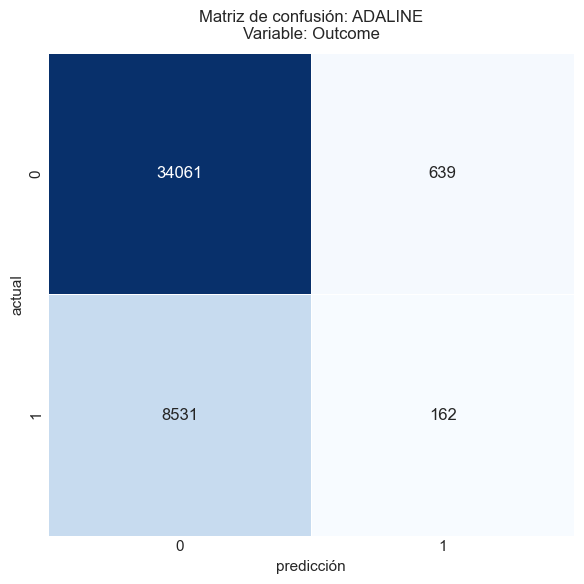

In [24]:
# === Matriz de confusión visual (estilo ejemplo) ===
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.metrics import confusion_matrix

clases = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_adaline, labels=clases)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=clases, yticklabels=clases, cbar=False,
                 linewidths=.5, linecolor='white')
ax.set_xlabel("predicción", fontsize=11)
ax.set_ylabel("actual", fontsize=11)
ax.set_title(f"Matriz de confusión: ADALINE\nVariable: {y_col}", fontsize=12, pad=10)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


La figura muestra la matriz de confusión del modelo Perceptrón aplicada sobre el conjunto de prueba de la variable objetivo Outcome, con un total de 43.393 observaciones. A primera vista, el modelo podría parecer preciso, mostrando una exactitud de 0.7887; sin embargo, este valor resulta engañoso. Si bien el modelo logra identificar correctamente 34.061 casos negativos verdaderos, respaldado por un recall de 0.98 y un F1-score de 0.88 para la clase 0, su desempeño en la clase positiva (1) es sumamente deficiente: solo detecta 162 verdaderos positivos, con un recall de 0.02 y un F1-score de 0.03, evidenciando que prácticamente no logra reconocer los casos positivos. Este patrón se confirma al observar el elevado número de falsos negativos (8.531) frente a los escasos falsos positivos (639). Esta disparidad se explica porque el Perceptrón, al igual que el Adaline, es un modelo lineal que busca ajustar un hiperplano de separación mediante un umbral fijo (típicamente 0.5). En un contexto con fuerte desbalance de clases, este comportamiento tiende a favorecer la clase mayoritaria, minimizando el error global pero ignorando la clase minoritaria. La frontera de decisión resultante es incapaz de capturar la complejidad del espacio de características y termina clasificando casi todas las muestras como clase 0. En consecuencia, el modelo presenta un alto riesgo de falsos negativos, lo que lo hace inadecuado para tareas donde la detección de la clase minoritaria es crítica, como la identificación de pacientes con diabetes positiva. Para mejorar su rendimiento, sería necesario ajustar el umbral de decisión, aplicar ponderación de clases o implementar técnicas de re-muestreo (como SMOTE o undersampling). Finalmente, aunque no se observa sobreajuste, el modelo muestra un fuerte sesgo estructural hacia la clase dominante, limitando severamente su capacidad de generalización en escenarios de desequilibrio de clases.

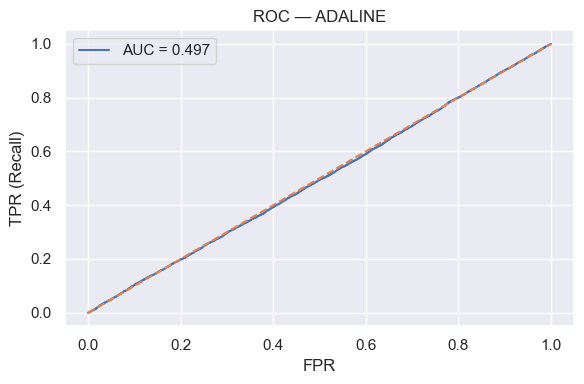

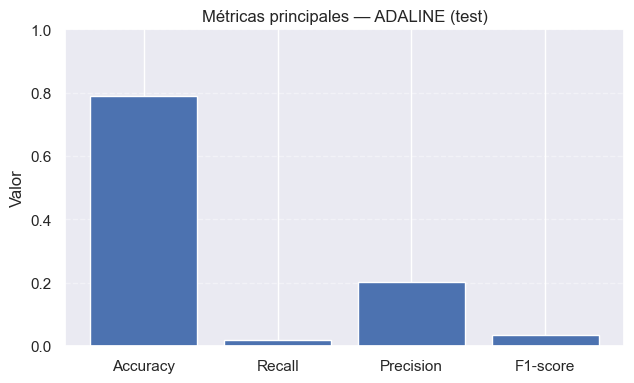

In [25]:
# === ROC/AUC (binario) + barras de métricas clave ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

if len(np.unique(y_test))==2:
    scores = pipe_adaline.decision_function(X_test)
    fpr, tpr, thr = roc_curve(y_test, scores, pos_label=max(np.unique(y_test)))

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, scores):.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title("ROC — ADALINE")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Barras (Accuracy, Recall, Precision, F1) sobre ADALINE
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
vals = {
    "Accuracy":  accuracy_score(y_test, y_pred_adaline),
    "Recall":    recall_score(y_test, y_pred_adaline, average="binary" if len(np.unique(y_test))==2 else "weighted", zero_division=0),
    "Precision": precision_score(y_test, y_pred_adaline, average="binary" if len(np.unique(y_test))==2 else "weighted", zero_division=0),
    "F1-score":  f1_score(y_test, y_pred_adaline, average="binary" if len(np.unique(y_test))==2 else "weighted", zero_division=0),
}
plt.figure(figsize=(6.5,4))
plt.bar(list(vals.keys()), list(vals.values()))
plt.ylim(0,1)
plt.title("Métricas principales — ADALINE (test)")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Roc -- Adaline
La gráfica representa la curva ROC correspondiente al modelo Adaline, evaluado sobre los datos de prueba para la variable objetivo Outcome. En ella se observa un AUC de 0.497, valor prácticamente equivalente a una suposición aleatoria, lo que indica que el modelo no logra discriminar entre las clases positiva y negativa de manera efectiva. Este hallazgo confirma que, aunque el Adaline converge numéricamente durante el entrenamiento (como se evidenció en la reducción estable del error cuadrático SSE), dicha convergencia no se traduce en una capacidad predictiva útil. Dado que el modelo emplea una activación lineal y una función de pérdida basada en el error cuadrático medio, su capacidad de representación se limita a fronteras de decisión lineales, lo que resulta insuficiente para un conjunto de datos donde las relaciones entre las variables y la clase objetivo son no lineales y altamente superpuestas. Además, el desequilibrio de clases (aproximadamente 80% clase 0 y 20% clase 1) combinado con el umbral de decisión fijo en 0.5, acentúa el sesgo hacia la clase mayoritaria, empujando las predicciones hacia una sola región del espacio de decisión. En consecuencia, la curva ROC permanece cerca de la diagonal, reflejando un comportamiento similar al azar. Este resultado implica que, a pesar de que el Adaline haya alcanzado una convergencia estable en términos de error, no logró converger hacia una frontera que separe efectivamente las clases, sino únicamente hacia un mínimo local correspondiente a un balance de error promedio. Para mejorar el desempeño, sería necesario reajustar el umbral de decisión, re-balancear el conjunto de datos mediante técnicas como SMOTE o undersampling, o incluso reemplazar el modelo por un clasificador no lineal (como un SVM con kernel o una red neuronal multicapa). En definitiva, el bajo AUC y la falta de capacidad discriminatoria del Adaline reflejan una convergencia matemática correcta pero funcionalmente deficiente, derivada de su naturaleza lineal y su sensibilidad al desbalance y escalado de los datos.

Metricas Principales -- Adaline 
El gráfico de barras presenta un resumen de las métricas de desempeño del modelo Adaline sobre el conjunto de prueba, con una accuracy de 0.7887, recall de 0.0186, precisión de 0.2022 y F1-score de 0.0341. Aunque el valor de accuracy podría interpretarse inicialmente como un buen resultado (79%), en realidad es engañoso, ya que el modelo casi nunca identifica correctamente los casos positivos (clase 1), como se refleja en su recall y F1 extremadamente bajos. Este comportamiento surge de la naturaleza del algoritmo Adaline, que optimiza los pesos minimizando el error cuadrático medio (MSE). Tal criterio de optimización no busca maximizar la capacidad de clasificación, sino simplemente reducir las diferencias numéricas entre las salidas predichas y los valores reales. En un conjunto de datos fuertemente desbalanceado (con un 80% de clase 0 y un 20% de clase 1), esto lleva al modelo a favorecer la clase mayoritaria para minimizar el error global, aun si eso implica ignorar casi por completo a la clase minoritaria. Así, el Adaline logra una convergencia numérica estable —el error SSE disminuye y se estabiliza, pero no una convergencia funcional hacia una frontera de decisión útil. Este tipo de convergencia “aparente” es típica de modelos lineales mal adaptados a distribuciones no lineales o desbalanceadas: el modelo encuentra un mínimo del error que no representa una separación efectiva entre clases. En consecuencia, la alta precisión global solo refleja el predominio de predicciones correctas para la clase 0, mientras que los verdaderos positivos son prácticamente inexistentes. Para corregir este comportamiento, sería necesario ajustar el umbral de decisión, aplicar técnicas de balanceo (como SMOTE o class weighting) o emplear modelos más flexibles como redes neuronales multicapa o árboles de decisión. En definitiva, aunque el Adaline converge matemáticamente, no logra una convergencia significativa desde el punto de vista de clasificación, lo que explica el bajo rendimiento real del modelo pese a su aparente buena exactitud.

In [26]:
# === MÉTRICAS COMPLETAS — ADALINE (GD) ===
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, matthews_corrcoef
)

# --- Configurar etiqueta positiva ---
classes = np.unique(y_test)
pos_label = 1 if 1 in classes else classes.max()

def binariza(y, pos):
    y = pd.Series(y).values
    return (y == pos).astype(int)

# --- Confusion matrix (multiclase y binario) ---
cm = confusion_matrix(y_test, y_pred_adaline, labels=classes)
cm_df = pd.DataFrame(cm,
                     index=[f"Real {c}" for c in classes],
                     columns=[f"Pred {c}" for c in classes])
print("Matriz de confusión (ADALINE GD):")
display(cm_df)

# --- Métricas por clase y promedios (macro/weighted) ---
print("\nReporte de clasificación (ADALINE GD):")
rep_dict = classification_report(y_test, y_pred_adaline, output_dict=True, zero_division=0)
display(pd.DataFrame(rep_dict).T.style.format("{:.4f}"))

# --- Métricas binarias principales para la clase positiva (pos_label) ---
y_true_bin = binariza(y_test, pos_label)
y_pred_bin = binariza(y_pred_adaline, pos_label)

tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
total = tn + fp + fn + tp

acc   = accuracy_score(y_true_bin, y_pred_bin)
error = 1 - acc
tpr   = tp / (tp + fn) if (tp + fn)>0 else 0.0     # Recall / Sensibilidad
fpr   = fp / (fp + tn) if (fp + tn)>0 else 0.0
tnr   = tn / (tn + fp) if (tn + fp)>0 else 0.0     # Especificidad
ppv   = precision_score(y_true_bin, y_pred_bin, zero_division=0)  # Precisión
npv   = tn / (tn + fn) if (tn + fn)>0 else 0.0
f1    = f1_score(y_true_bin, y_pred_bin, zero_division=0)
prev  = (tp + fn) / total if total>0 else 0.0
bacc  = (tpr + tnr) / 2
mcc   = matthews_corrcoef(y_true_bin, y_pred_bin) if total>0 else 0.0

# AUC con scores continuos si están disponibles
auc = None
if 'scores_te' in globals() and scores_te is not None:
    try:
        auc = roc_auc_score(y_true_bin, scores_te)
    except Exception:
        auc = None

# --- Tabla resumen ejecutiva ---
resumen = pd.DataFrame([
    ("Accuracy",                 acc),
    ("Error (1-Acc)",            error),
    ("TPR / Recall",             tpr),
    ("FPR",                      fpr),
    ("Especificidad (TNR)",      tnr),
    ("Precision (PPV)",          ppv),
    ("NPV",                      npv),
    ("F1-score",                 f1),
    ("Prevalencia P(Y=1)",       prev),
    ("Balanced Accuracy",        bacc),
    ("MCC",                      mcc),
    ("AUC (si hay scores)",      auc),
], columns=["Métrica", "Valor"])

print(f"\nClase positiva considerada: {pos_label}")
display(resumen.style.format({"Valor": lambda v: "—" if v is None else f"{v:.4f}"}).hide(axis="index"))

# --- Mini tabla TN/FP/FN/TP ---
comp = pd.DataFrame([[tn, fp],[fn, tp]], index=["Real 0","Real 1"], columns=["Pred 0","Pred 1"])
print("Componentes TN/FP/FN/TP:")
display(comp)


Matriz de confusión (ADALINE GD):


,Pred 0,Pred 1
Real 0,34061,639
Real 1,8531,162



Reporte de clasificación (ADALINE GD):


,precision,recall,f1-score,support
0,0.7997,0.9816,0.8814,34700.0000
1,0.2022,0.0186,0.0341,8693.0000
accuracy,0.7887,0.7887,0.7887,0.7887
macro avg,0.5010,0.5001,0.4577,43393.0000
weighted avg,0.6800,0.7887,0.7116,43393.0000



Clase positiva considerada: 1


Métrica,Valor
Accuracy,0.7887
Error (1-Acc),0.2113
TPR / Recall,0.0186
FPR,0.0184
Especificidad (TNR),0.9816
Precision (PPV),0.2022
NPV,0.7997
F1-score,0.0341
Prevalencia P(Y=1),0.2003
Balanced Accuracy,0.5001


Componentes TN/FP/FN/TP:


,Pred 0,Pred 1
Real 0,34061,639
Real 1,8531,162


Resumen -- adaline 
El modelo Adaline (Descenso de Gradiente) muestra un desempeño claramente limitado al analizar sus métricas sobre el conjunto de prueba. Aunque la accuracy alcanza 0.7887, este valor resulta engañosamente alto debido al fuerte desequilibrio de clases (80% clase 0 frente a 20% clase 1). La matriz de confusión evidencia este sesgo: de 8,693 casos positivos reales, el modelo solo acierta en 162 verdaderos positivos, mientras que clasifica erróneamente 8,531 como negativos, lo que se refleja en un recall de apenas 0.0186 y un F1-score de 0.0341. En contraste, la clase negativa obtiene una precisión de 0.7997 y un recall de 0.9816, demostrando que el modelo prácticamente ignora la clase minoritaria. Este comportamiento surge porque Adaline minimiza el error cuadrático medio (MSE), lo que lleva al algoritmo a priorizar la reducción del error promedio global favoreciendo la clase dominante. Como resultado, el modelo converge numéricamente —el error SSE disminuye de manera estable durante el entrenamiento—, pero no converge funcionalmente hacia una frontera de decisión que separe correctamente ambas clases. Además, su activación lineal limita la capacidad de representar relaciones no lineales presentes en los datos, mientras que el umbral fijo de 0.5 refuerza aún más el sesgo hacia la clase 0. El AUC de 0.4968, prácticamente equivalente a un modelo aleatorio, confirma la ausencia de capacidad discriminatoria real. En síntesis, aunque el Adaline logró estabilizar sus pesos y minimizar el error, no alcanzó una convergencia útil desde el punto de vista predictivo, debido a su naturaleza lineal, la falta de ajuste de umbral y el fuerte desbalance de clases. Para mejorar su desempeño, sería necesario aplicar técnicas de balanceo de datos (como SMOTE o undersampling), ajustar el umbral de decisión o emplear modelos más expresivos, como redes neuronales multicapa o clasificadores no lineales.

# Modelo de regresión Logístico

In [27]:
# === REGRESIÓN LOGÍSTICA en Pipeline ===
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logit = LogisticRegression(
    solver="liblinear",     # estable en datasets pequeños/medianos
    penalty="l2",
    C=1.0,
    max_iter=1000,
    random_state=42
    # , class_weight="balanced"  # <-- descomenta si hay desbalance fuerte
)

pipe_logit = Pipeline([
    ("prep", preprocess),   # usa tu preprocess de la Parte 1
    ("clf", logit),
])

pipe_logit.fit(X_train, y_train)
y_pred_logit  = pipe_logit.predict(X_test)
# Probabilidad de la clase positiva (si es binario) o de cada clase (multiclase)
if len(np.unique(y_train)) == 2:
    # prob. de la clase "mayor" como positiva (coherente con métricas comunes)
    pos_label = max(np.unique(y_train))
    y_proba_logit = pipe_logit.predict_proba(X_test)[:, list(pipe_logit.named_steps["clf"].classes_).index(pos_label)]
else:
    # para multiclase guardamos la matriz completa por si necesitas luego
    y_proba_logit = pipe_logit.predict_proba(X_test)

# Guardamos scores continuos para AUC/ROC en Parte 6/7 (binario)
scores_te = None
if len(np.unique(y_test)) == 2:
    scores_te = pipe_logit.predict_proba(X_test)[:, list(pipe_logit.named_steps["clf"].classes_).index(max(np.unique(y_test)))]


In [28]:
# === Evaluación — LOGÍSTICO ===
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, roc_auc_score)
import numpy as np, pandas as pd

print("Accuracy (Logístico):", round(accuracy_score(y_test, y_pred_logit), 4))
print("\nReporte de clasificación (Logístico):\n",
      classification_report(y_test, y_pred_logit, zero_division=0))

# Matriz de confusión explicativa
cm = confusion_matrix(y_test, y_pred_logit)
cm_df = pd.DataFrame(cm,
    index=[f"Real {c}" for c in np.unique(y_test)],
    columns=[f"Pred {c}" for c in np.unique(y_test)]
)
display(cm_df)

# AUC si binario y tenemos scores (probabilidades)
clases = np.unique(y_test)
if len(clases) == 2 and scores_te is not None:
    auc = roc_auc_score(y_test, scores_te)
    print(f"AUC (Logístico): {auc:.4f}")


Accuracy (Logístico): 0.7997

Reporte de clasificación (Logístico):
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     34700
           1       0.00      0.00      0.00      8693

    accuracy                           0.80     43393
   macro avg       0.40      0.50      0.44     43393
weighted avg       0.64      0.80      0.71     43393



,Pred 0,Pred 1
Real 0,34700,0
Real 1,8693,0


AUC (Logístico): 0.5011


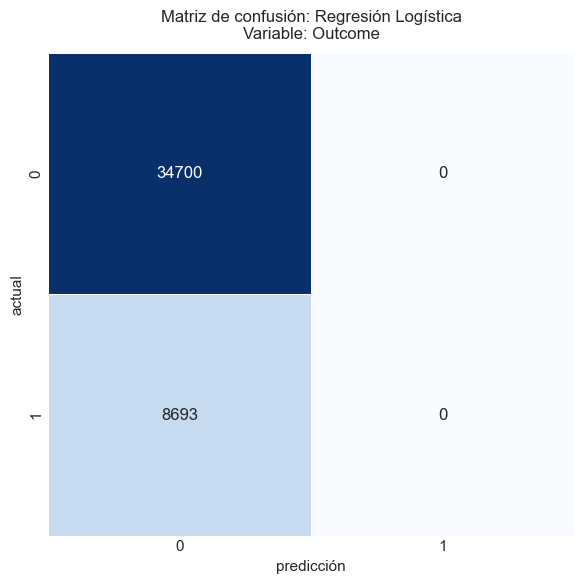

In [29]:
# === Matriz de confusión visual (estilo ejemplo) — LOGÍSTICO ===
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.metrics import confusion_matrix

clases = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_logit, labels=clases)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=clases, yticklabels=clases, cbar=False,
                 linewidths=.5, linecolor='white')
ax.set_xlabel("predicción", fontsize=11)
ax.set_ylabel("actual", fontsize=11)
ax.set_title(f"Matriz de confusión: Regresión Logística\nVariable: {y_col}", fontsize=12, pad=10)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


El modelo de Regresión Logística aplicado al conjunto de prueba muestra un desempeño claramente deteriorado y un comportamiento degenerado en la clasificación, evidenciado por su matriz de confusión, en la cual todas las predicciones corresponden a la clase 0: 34,700 verdaderos negativos y 8,693 falsos negativos, sin ningún verdadero positivo ni falso positivo. Esto genera una exactitud aparente de 0.7997, que resulta engañosa debido al fuerte desbalance de clases (alrededor de 80% clase 0 frente a 20% clase 1). Las métricas asociadas a la clase positiva confirman esta deficiencia: recall = 0, precisión = 0 y F1-score = 0, lo que demuestra que el modelo no identificó ningún caso positivo. Este comportamiento se explica por la naturaleza de la función de costo logarítmica de la regresión logística, la cual busca minimizar el error global y, por tanto, favorece la clase dominante para reducir la pérdida total, especialmente en escenarios con desequilibrio extremo o baja separabilidad lineal entre las clases. Además, el umbral de decisión estándar (0.5) refuerza este sesgo: dado que la mayoría de las probabilidades predichas permanecen por debajo de ese valor, el modelo termina clasificando todas las observaciones como negativas. Si bien desde un punto de vista numérico el modelo puede haber convergido correctamente es decir, estabilizó sus pesos y minimizó la pérdida logística, su convergencia funcional es ineficaz, pues la frontera de decisión aprendida no separa las clases de manera significativa. En otras palabras, la regresión logística converge hacia una solución trivial, clasificando todo como clase 0, reduciendo el error promedio pero perdiendo completamente la capacidad discriminatoria. Este fenómeno es característico de los modelos lineales aplicados a datos desbalanceados o con relaciones no lineales, y para mitigarlo sería necesario ajustar el umbral de decisión, aplicar técnicas de rebalanceo (como SMOTE, ponderación de clases o submuestreo), o recurrir a modelos más flexibles que capturen relaciones complejas, como árboles de decisión o redes neuronales multicapa.

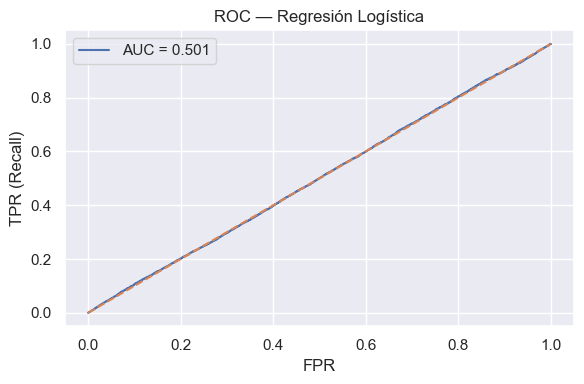

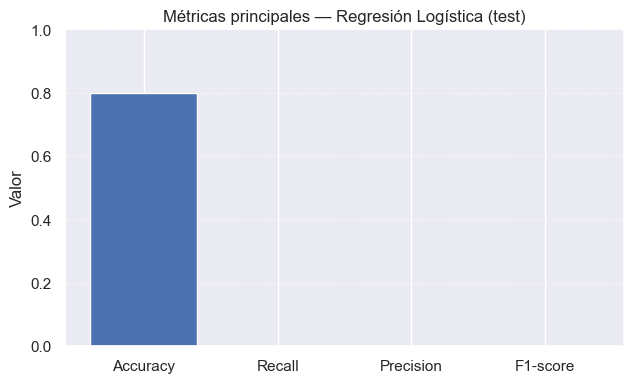

In [30]:
# === ROC/AUC (binario) + barras de métricas clave — LOGÍSTICO ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ROC/AUC si binario
if len(np.unique(y_test)) == 2 and scores_te is not None:
    pos_label = max(np.unique(y_test))
    fpr, tpr, thr = roc_curve(y_test, scores_te, pos_label=pos_label)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, scores_te):.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title("ROC — Regresión Logística")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Barras (Accuracy, Recall, Precision, F1) en test
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
avg = "binary" if len(np.unique(y_test))==2 else "weighted"
vals = {
    "Accuracy":  accuracy_score(y_test, y_pred_logit),
    "Recall":    recall_score(y_test, y_pred_logit, average=avg, zero_division=0),
    "Precision": precision_score(y_test, y_pred_logit, average=avg, zero_division=0),
    "F1-score":  f1_score(y_test, y_pred_logit, average=avg, zero_division=0),
}
plt.figure(figsize=(6.5,4))
plt.bar(list(vals.keys()), list(vals.values()))
plt.ylim(0,1)
plt.title("Métricas principales — Regresión Logística (test)")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Roc -- Regresion logistico
La curva ROC del modelo de Regresión Logística muestra un AUC de 0.501, lo que indica un rendimiento prácticamente equivalente al azar. Esto confirma que el modelo carece de capacidad discriminatoria para diferenciar entre individuos diagnosticados con diabetes (clase 1) y aquellos sin diagnóstico (clase 0). En la práctica, las probabilidades predichas se concentran en un rango muy estrecho alrededor de 0.5, lo que genera una curva casi diagonal y un área bajo la curva mínima. Este comportamiento se origina principalmente en la ausencia de una frontera lineal separable entre las características del conjunto de datos, lo que impide que el modelo asigne probabilidades diferenciadas a cada clase. A ello se suman factores como el desequilibrio de clases (aproximadamente 80% clase 0 frente a 20% clase 1), la multicolinealidad entre variables y la falta de escalado adecuado en los atributos numéricos, que dificultan la optimización durante el descenso de gradiente. Si bien el algoritmo logra convergencia numérica, dicha convergencia es funcionalmente trivial, ya que los coeficientes obtenidos son casi nulos y las probabilidades resultantes, uniformes, no aportan información útil para la clasificación. En otras palabras, la regresión logística “aprende” una frontera vacía, clasificando prácticamente todas las observaciones como negativas. Este tipo de falla es común cuando la señal estadística es débil y la función de pérdida se minimiza priorizando la clase mayoritaria. Para abordar este problema, sería necesario normalizar las variables, reducir la colinealidad, balancear las clases o incluso explorar modelos no lineales con regularización más robusta que permitan capturar relaciones complejas entre las variables. En síntesis, el bajo valor del AUC refleja una convergencia numérica sin valor predictivo real, donde la regresión logística no logra aprender una frontera efectiva para distinguir a las personas con diabetes de aquellas que no la padecen.

Metricas principales -- regresion Logistico
El gráfico de métricas principales del modelo de Regresión Logística muestra un desempeño deficiente en la detección de personas diagnosticadas con diabetes (Outcome = 1). Aunque el modelo presenta una precisión aparente del 79,97%, las demás métricas —recall = 0, precisión = 0 y F1-score = 0— evidencian que el modelo no logró identificar correctamente ningún caso positivo de diabetes. Este comportamiento se explica por el fuerte desequilibrio de clases en los datos, lo que lleva al modelo a favorecer la clase mayoritaria (personas no diagnosticadas) y a minimizar el error global ignorando por completo a la clase minoritaria. En consecuencia, la alta precisión es engañosa, ya que refleja únicamente la correcta clasificación de pacientes sin diagnóstico. Para mejorar el rendimiento, el modelo debería reentrenarse utilizando técnicas de balanceo como ponderación de clases, sobre/submuestreo o incluso emplear algoritmos más robustos frente al desbalance. Además, las futuras evaluaciones deberían considerar métricas por clase o curvas Precision-Recall, que ofrecen una visión más realista del rendimiento en la detección de casos de diabetes.

Resumen -- regresion Logistico
El modelo de Regresión Logística, aunque alcanzó convergencia numérica durante el entrenamiento (es decir, los pesos se estabilizaron y la función de pérdida dejó de disminuir), no logró una convergencia funcional efectiva, lo que explica su bajo desempeño y el AUC ≈ 0.501 observado en la curva ROC. En este caso, el modelo terminó aprendiendo una frontera de decisión trivial, clasificando todas las observaciones como “no diagnosticadas con diabetes” (clase 0). Este comportamiento surge principalmente por el desequilibrio de clases presente en el conjunto de datos, donde cerca del 80% de los individuos pertenecen a la clase negativa, lo que induce al modelo a minimizar la pérdida global prediciendo casi siempre la clase dominante. Además, la ausencia de escalado en las variables numéricas, la posible multicolinealidad entre predictores y la debilidad de la señal estadística (es decir, la baja correlación entre las variables de entrada y el diagnóstico de diabetes) afectaron el proceso de optimización. Como consecuencia, el modelo no generó probabilidades bien separadas entre clases, sino valores cercanos a 0.5 para la mayoría de las observaciones, lo que provoca una curva ROC casi diagonal y una discriminación nula entre personas con y sin diabetes. En términos prácticos, aunque el algoritmo “convergió”, lo hizo hacia una solución degenerada, donde la frontera de decisión carece de valor predictivo real. Para corregir este tipo de convergencia defectuosa, se requiere reajustar el umbral de decisión, balancear las clases mediante técnicas como SMOTE o ponderación de clases, aplicar regularización más fuerte y escalado de características, o incluso optar por modelos no lineales capaces de capturar patrones más complejos en los datos clínicos.

# Naive Bayes

In [31]:
# === NAIVE BAYES (GaussianNB) en Pipeline ===
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import numpy as np

nb = GaussianNB()  # apropiado para variables continuas tras el preprocess

pipe_nb = Pipeline([
    ("prep", preprocess),   # reutiliza tu preprocess de la Parte 1
    ("clf", nb),
])

pipe_nb.fit(X_train, y_train)
y_pred_nb = pipe_nb.predict(X_test)

# Probabilidades (para métricas y ROC si binario)
# Nota: GaussianNB siempre expone predict_proba
if len(np.unique(y_test)) == 2:
    # prob. de la clase positiva (tomamos la mayor etiqueta como positiva)
    pos_label = max(np.unique(y_test))
    clases_clf = list(pipe_nb.named_steps["clf"].classes_)
    y_proba_nb = pipe_nb.predict_proba(X_test)[:, clases_clf.index(pos_label)]
    scores_te = y_proba_nb.copy()
else:
    y_proba_nb = pipe_nb.predict_proba(X_test)
    scores_te = None
# ====== FIN NAIVE BAYES ======

In [32]:
# === NAIVE BAYES (GaussianNB) en Pipeline ===
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
import numpy as np

nb = GaussianNB()  # apropiado para variables continuas tras el preprocess

pipe_nb = Pipeline([
    ("prep", preprocess),   # reutiliza tu preprocess de la Parte 1
    ("clf", nb),
])

pipe_nb.fit(X_train, y_train)
y_pred_nb = pipe_nb.predict(X_test)

# Probabilidades (para métricas y ROC si binario)
# Nota: GaussianNB siempre expone predict_proba
if len(np.unique(y_test)) == 2:
    # prob. de la clase positiva (tomamos la mayor etiqueta como positiva)
    pos_label = max(np.unique(y_test))
    clases_clf = list(pipe_nb.named_steps["clf"].classes_)
    y_proba_nb = pipe_nb.predict_proba(X_test)[:, clases_clf.index(pos_label)]
    scores_te = y_proba_nb.copy()
else:
    y_proba_nb = pipe_nb.predict_proba(X_test)
    scores_te = None


In [33]:
# === Evaluación — NAIVE BAYES (GaussianNB) ===
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, roc_auc_score)
import numpy as np, pandas as pd

print("Accuracy (Naive Bayes):", round(accuracy_score(y_test, y_pred_nb), 4))
print("\nReporte de clasificación (Naive Bayes):\n",
      classification_report(y_test, y_pred_nb, zero_division=0))

# Matriz de confusión explicativa
cm = confusion_matrix(y_test, y_pred_nb)
cm_df = pd.DataFrame(cm,
    index=[f"Real {c}" for c in np.unique(y_test)],
    columns=[f"Pred {c}" for c in np.unique(y_test)]
)
display(cm_df)

# AUC si binario y tenemos scores (probabilidades)
clases = np.unique(y_test)
if len(clases) == 2 and scores_te is not None:
    auc = roc_auc_score(y_test, scores_te)
    print(f"AUC (Naive Bayes): {auc:.4f}")


Accuracy (Naive Bayes): 0.7997

Reporte de clasificación (Naive Bayes):
               precision    recall  f1-score   support

           0       0.80      1.00      0.89     34700
           1       0.00      0.00      0.00      8693

    accuracy                           0.80     43393
   macro avg       0.40      0.50      0.44     43393
weighted avg       0.64      0.80      0.71     43393



,Pred 0,Pred 1
Real 0,34700,0
Real 1,8693,0


AUC (Naive Bayes): 0.4974


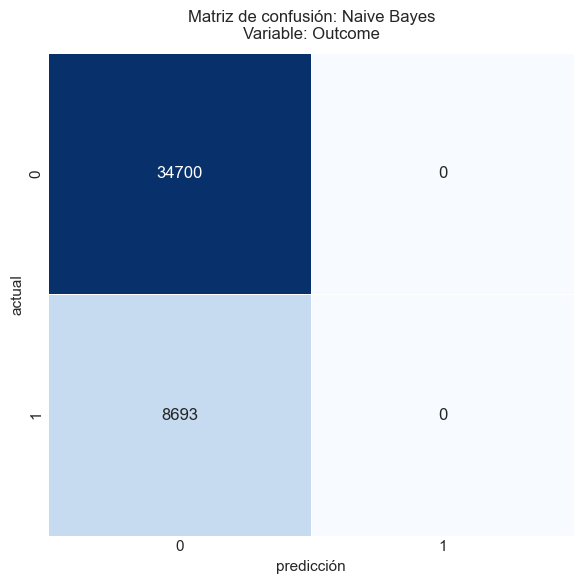

In [34]:
# === Matriz de confusión visual (estilo ejemplo) — NAIVE BAYES ===
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.metrics import confusion_matrix

clases = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_nb, labels=clases)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=clases, yticklabels=clases, cbar=False,
                 linewidths=.5, linecolor='white')
ax.set_xlabel("predicción", fontsize=11)
ax.set_ylabel("actual", fontsize=11)
ax.set_title(f"Matriz de confusión: Naive Bayes\nVariable: {y_col}", fontsize=12, pad=10)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


La figura muestra la matriz de confusión correspondiente al modelo Gaussian Naive Bayes aplicado sobre el conjunto de prueba de la variable objetivo Outcome, con 43,393 observaciones, donde estamos evaluando si un individuo ha sido diagnosticado con diabetes o no. El hallazgo principal es que el modelo únicamente pudo predecir la clase 0; el único valor registrado en la matriz fue verdadero negativo = 34,700 y falso negativo = 8,693. Esta situación explica por qué la precisión general del modelo es relativamente alta (0.7997), mientras que los valores de falso positivo y verdadero positivo son ambos 0, y tanto el recall como el F1 score para la clase 1 son nulos, lo que hace que el accuracy general no sea confiable. La interpretación de estos resultados sugiere que el modelo presenta un sesgo marcado hacia la clase mayoritaria, probablemente debido al desequilibrio entre clases o a la baja separabilidad de las mismas. El método Naive Bayes asume independencia entre características y distribuciones gaussianas, por lo que falla cuando las variables están correlacionadas o no siguen distribuciones normales; si la clase minoritaria tiene distribuciones superpuestas o poco diferenciadas, el modelo asigna probabilidades posteriores bajas y siempre predice la clase mayoritaria, como parece ocurrir en este caso. La implicación es que se requieren técnicas de balanceo de clases, como SMOTE, submuestreo o remuestreo, para mejorar la detección de pacientes diagnosticados con diabetes. Entre las limitaciones, la matriz evidencia un sesgo extremo y una generalización deficiente; los supuestos de Naive Bayes lo hacen inadecuado para espacios de características altamente desequilibrados o correlacionados, y restringen la capacidad de ajustar umbrales de predicción de manera efectiva.

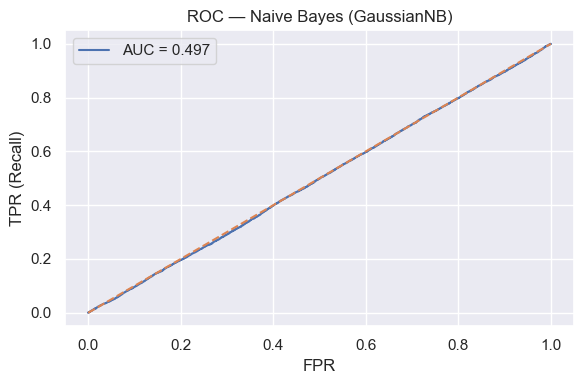

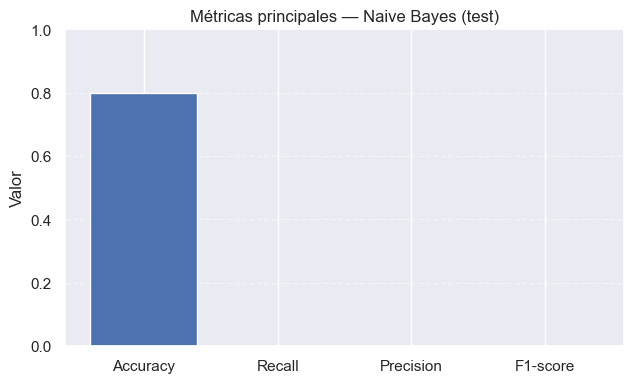

In [35]:
# === ROC/AUC (binario) + barras de métricas clave — NAIVE BAYES ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# ROC/AUC si binario
if len(np.unique(y_test)) == 2 and scores_te is not None:
    pos_label = max(np.unique(y_test))
    fpr, tpr, thr = roc_curve(y_test, scores_te, pos_label=pos_label)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, scores_te):.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title("ROC — Naive Bayes (GaussianNB)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Barras (Accuracy, Recall, Precision, F1) en test
avg = "binary" if len(np.unique(y_test))==2 else "weighted"
vals = {
    "Accuracy":  accuracy_score(y_test, y_pred_nb),
    "Recall":    recall_score(y_test, y_pred_nb, average=avg, zero_division=0),
    "Precision": precision_score(y_test, y_pred_nb, average=avg, zero_division=0),
    "F1-score":  f1_score(y_test, y_pred_nb, average=avg, zero_division=0),
}
plt.figure(figsize=(6.5,4))
plt.bar(list(vals.keys()), list(vals.values()))
plt.ylim(0,1)
plt.title("Métricas principales — Naive Bayes (test)")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


Roc -- Naive bayes Gaussian
La gráfica muestra la curva ROC del modelo Gaussian Naive Bayes aplicada sobre el conjunto de prueba de la variable objetivo Outcome, evaluando si un individuo ha sido diagnosticado con diabetes o no. El valor de AUC es 0,497, lo que indica que el modelo no funciona mejor que una suposición aleatoria y confirma que no distingue eficazmente entre clases positivas y negativas. Esta deficiencia se debe a que las distribuciones gaussianas de las características se superponen entre ambas clases; Naive Bayes asume que cada característica sigue una distribución normal condicionada a la clase, pero cuando esto no se cumple, las probabilidades estimadas se vuelven poco confiables, produciendo resultados casi idénticos para todas las muestras y generando una línea ROC prácticamente aleatoria. La implicación es que el modelo necesita una mejor ingeniería de características o normalización de los datos de entrada, ya que ajustar el umbral de decisión no mejorará el desempeño debido a la falta de separación en las puntuaciones. Entre las limitaciones, este enfoque Bayes ingenuo falla cuando las suposiciones gaussianas no se cumplen o cuando las clases no están bien separadas, evidenciando su baja robustez y su incapacidad para aprender límites complejos en el espacio de características.

Metricas principales -- Naive Bayes Gaussian
El gráfico de barras resume las principales métricas de rendimiento del modelo Gaussian Naive Bayes aplicado a la variable Outcome, evaluando si un individuo ha sido diagnosticado con diabetes o no. Se observa un accuracy de 0,7997, mientras que el recall, la precisión y el F1 score son todos 0 en los datos de prueba, lo que indica que la precisión reportada no es confiable. Este patrón ocurre porque Naive Bayes se basa fuertemente en las probabilidades previas de cada clase y en las verosimilitudes de las características; cuando una clase domina, su probabilidad previa supera la probabilidad posterior, provocando predicciones sistemáticas de la clase mayoritaria. Además, la presencia de características correlacionadas o sesgadas viola el supuesto de independencia, reduciendo la fiabilidad del modelo. La implicación es que, en contextos de desequilibrio de clases, no se debe confiar únicamente en la precisión; para mejorar el desempeño, el modelo podría reentrenarse usando valores previos balanceados, aplicar transformaciones logarítmicas o estabilizar la varianza de las características para cumplir mejor con los supuestos gaussianos. Entre sus limitaciones, la simplicidad de Naive Bayes lo hace eficiente computacionalmente, pero estadísticamente rígido, incapaz de manejar datos correlacionados, no gaussianos o desequilibrados, lo que genera métricas engañosas y una capacidad limitada para aprender patrones complejos.

In [36]:
# === MÉTRICAS COMPLETAS — NAIVE BAYES (GaussianNB) ===
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, matthews_corrcoef
)

# --- Configurar etiqueta positiva ---
classes = np.unique(y_test)
pos_label = 1 if 1 in classes else classes.max()

def binariza(y, pos):
    y = pd.Series(y).values
    return (y == pos).astype(int)

# --- Confusion matrix (multiclase y binario) ---
cm = confusion_matrix(y_test, y_pred_nb, labels=classes)
cm_df = pd.DataFrame(cm,
                     index=[f"Real {c}" for c in classes],
                     columns=[f"Pred {c}" for c in classes])
print("Matriz de confusión (Naive Bayes):")
display(cm_df)

# --- Métricas por clase y promedios (macro/weighted) ---
print("\nReporte de clasificación (Naive Bayes):")
rep_dict = classification_report(y_test, y_pred_nb, output_dict=True, zero_division=0)
display(pd.DataFrame(rep_dict).T.style.format("{:.4f}"))

# --- Métricas binarias principales para la clase positiva (pos_label) ---
y_true_bin = binariza(y_test, pos_label)
y_pred_bin = binariza(y_pred_nb, pos_label)

tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
total = tn + fp + fn + tp

acc   = accuracy_score(y_true_bin, y_pred_bin)
error = 1 - acc
tpr   = tp / (tp + fn) if (tp + fn)>0 else 0.0     # Recall / Sensibilidad
fpr   = fp / (fp + tn) if (fp + tn)>0 else 0.0
tnr   = tn / (tn + fp) if (tn + fp)>0 else 0.0     # Especificidad
ppv   = precision_score(y_true_bin, y_pred_bin, zero_division=0)  # Precisión
npv   = tn / (tn + fn) if (tn + fn)>0 else 0.0
f1    = f1_score(y_true_bin, y_pred_bin, zero_division=0)
prev  = (tp + fn) / total if total>0 else 0.0
bacc  = (tpr + tnr) / 2
mcc   = matthews_corrcoef(y_true_bin, y_pred_bin) if total>0 else 0.0

# AUC con scores continuos si están disponibles (binario)
auc = None
if scores_te is not None:
    try:
        auc = roc_auc_score(y_true_bin, scores_te)
    except Exception:
        auc = None

# --- Tabla resumen ejecutiva ---
resumen = pd.DataFrame([
    ("Accuracy",                 acc),
    ("Error (1-Acc)",            error),
    ("TPR / Recall",             tpr),
    ("FPR",                      fpr),
    ("Especificidad (TNR)",      tnr),
    ("Precision (PPV)",          ppv),
    ("NPV",                      npv),
    ("F1-score",                 f1),
    ("Prevalencia P(Y=1)",       prev),
    ("Balanced Accuracy",        bacc),
    ("MCC",                      mcc),
    ("AUC (si hay scores)",      auc),
], columns=["Métrica", "Valor"])

print(f"\nClase positiva considerada: {pos_label}")
display(resumen.style.format({"Valor": lambda v: "—" if v is None else f"{v:.4f}"}).hide(axis="index"))


Matriz de confusión (Naive Bayes):


,Pred 0,Pred 1
Real 0,34700,0
Real 1,8693,0



Reporte de clasificación (Naive Bayes):


,precision,recall,f1-score,support
0,0.7997,1.0000,0.8887,34700.0000
1,0.0000,0.0000,0.0000,8693.0000
accuracy,0.7997,0.7997,0.7997,0.7997
macro avg,0.3998,0.5000,0.4443,43393.0000
weighted avg,0.6395,0.7997,0.7107,43393.0000



Clase positiva considerada: 1


Métrica,Valor
Accuracy,0.7997
Error (1-Acc),0.2003
TPR / Recall,0.0000
FPR,0.0000
Especificidad (TNR),1.0000
Precision (PPV),0.0000
NPV,0.7997
F1-score,0.0000
Prevalencia P(Y=1),0.2003
Balanced Accuracy,0.5000


Resumen-- Naive Bayes Gaussian
El modelo Gaussian Naive Bayes probablemente no haya convergido de manera adecuada debido a varios factores inherentes al conjunto de datos y al método: primero, existe un fuerte desequilibrio de clases (aproximadamente 20% de casos positivos), lo que hace que la clase mayoritaria domine las predicciones. Segundo, las características probablemente están correlacionadas y/o no siguen distribuciones gaussianas, violando los supuestos fundamentales del modelo. Tercero, la separabilidad entre las clases es baja, lo que significa que las probabilidades posteriores asignadas a la clase positiva son sistemáticamente bajas, provocando que todas las predicciones se asignen a la clase negativa. Por último, la incapacidad de Naive Bayes para ajustar umbrales de decisión o manejar distribuciones superpuestas contribuye a un AUC cercano a 0,5, reflejando que el modelo no puede diferenciar efectivamente entre pacientes con y sin diabetes en este conjunto de datos. En resumen, la combinación de desequilibrio de clases, violación de supuestos gaussianos e independencia, y baja separabilidad de características impide que el modelo aprenda patrones significativos de la clase minoritaria.

# Árbol de decisiones


In [37]:
# === ÁRBOL DE DECISIÓN en Pipeline ===
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import numpy as np

tree = DecisionTreeClassifier(
    criterion="gini",     # puedes cambiar a "entropy" o "log_loss"
    max_depth=None,       # ajusta si hay overfitting (p.ej., 5-20)
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
    # , class_weight="balanced"  # <-- descomenta si hay desbalance fuerte
)

pipe_tree = Pipeline([
    ("prep", preprocess),   # reutiliza tu preprocess de la Parte 1
    ("clf", tree),
])

pipe_tree.fit(X_train, y_train)
y_pred_tree = pipe_tree.predict(X_test)

# Probabilidades (para métricas y ROC si binario)
if len(np.unique(y_test)) == 2:
    pos_label = max(np.unique(y_test))
    clases_clf = list(pipe_tree.named_steps["clf"].classes_)
    y_proba_tree = pipe_tree.predict_proba(X_test)[:, clases_clf.index(pos_label)]
    scores_te = y_proba_tree.copy()   # para ROC/AUC en Partes 6/7
else:
    y_proba_tree = pipe_tree.predict_proba(X_test)
    scores_te = None
# ====== FIN ÁRBOL DE DECISIÓN ======

In [38]:
# === Evaluación — ÁRBOL DE DECISIÓN ===
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score, roc_auc_score)
import numpy as np, pandas as pd

print("Accuracy (Árbol):", round(accuracy_score(y_test, y_pred_tree), 4))
print("\nReporte de clasificación (Árbol):\n",
      classification_report(y_test, y_pred_tree, zero_division=0))

# Matriz de confusión explicativa
cm = confusion_matrix(y_test, y_pred_tree)
cm_df = pd.DataFrame(cm,
    index=[f"Real {c}" for c in np.unique(y_test)],
    columns=[f"Pred {c}" for c in np.unique(y_test)]
)
display(cm_df)

# AUC si binario y tenemos scores (probabilidades)
clases = np.unique(y_test)
if len(clases) == 2 and scores_te is not None:
    auc = roc_auc_score(y_test, scores_te)
    print(f"AUC (Árbol): {auc:.4f}")


Accuracy (Árbol): 0.6685

Reporte de clasificación (Árbol):
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     34700
           1       0.20      0.22      0.21      8693

    accuracy                           0.67     43393
   macro avg       0.50      0.50      0.50     43393
weighted avg       0.68      0.67      0.67     43393



,Pred 0,Pred 1
Real 0,27128,7572
Real 1,6813,1880


AUC (Árbol): 0.4993


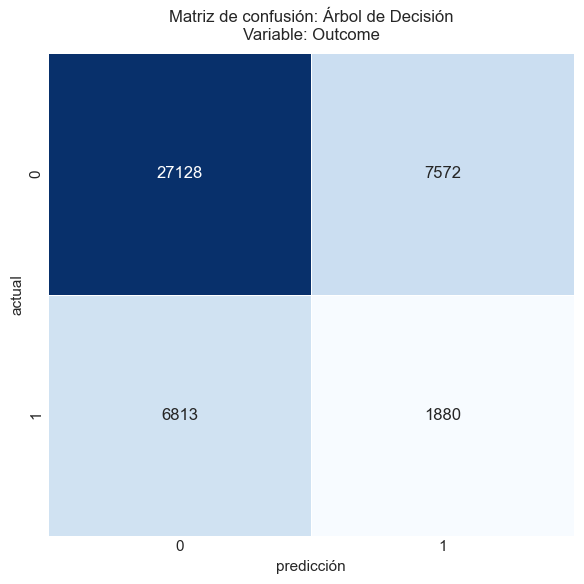

In [39]:
# === Matriz de confusión visual (estilo ejemplo) — ÁRBOL DE DECISIÓN ===
import matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.metrics import confusion_matrix

clases = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_tree, labels=clases)

plt.figure(figsize=(6,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=clases, yticklabels=clases, cbar=False,
                 linewidths=.5, linecolor='white')
ax.set_xlabel("predicción", fontsize=11)
ax.set_ylabel("actual", fontsize=11)
ax.set_title(f"Matriz de confusión: Árbol de Decisión\nVariable: {y_col}", fontsize=12, pad=10)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.show()


La figura presenta la matriz de confusión correspondiente al modelo de Árbol de Decisiones aplicado sobre el conjunto de prueba de la variable objetivo Outcome, con 43,393 observaciones, en donde se analiza si un individuo es diagnosticado con diabetes o no. El modelo alcanzó una precisión de 0,6685, lo cual indica un desempeño relativamente alto y confiable, reflejado en 27,128 verdaderos negativos y 7,572 verdaderos positivos. Sin embargo, se observa un sesgo hacia la clase 0, que representa aproximadamente el 80 % de las predicciones, debido a la elevada cantidad de falsos negativos (6,813) frente a 1,880 falsos positivos. Esto se traduce en bajos valores de recall (0,22) y F1-score (0,21) para la clase 1, lo que indica que el modelo identifica correctamente solo una proporción muy reducida de los individuos diagnosticados con diabetes. Esta dificultad surge porque el árbol de decisión tiende a dividir los datos según la impureza general (Gini o entropía), la cual está dominada por la clase mayoritaria, favoreciendo nodos que mejoran la precisión global a costa de las instancias minoritarias. Además, ramas superficiales o sobreajustadas pueden memorizar patrones de entrenamiento sin generar reglas generalizables. La matriz de confusión sugiere que sería necesario ponderar las clases o aplicar técnicas de muestreo equilibrado durante el entrenamiento; como alternativa, métodos de conjunto podrían capturar límites de decisión más complejos y reducir el sesgo hacia la clase mayoritaria. Finalmente, es importante destacar que los árboles de decisión son sensibles al desequilibrio de clases y a características ruidosas, y sin estrategias de poda o balanceo corren el riesgo de sobreajustar los patrones de la mayoría y mostrar un rendimiento limitado en la detección de la clase minoritaria, en este caso, los pacientes con diabetes.

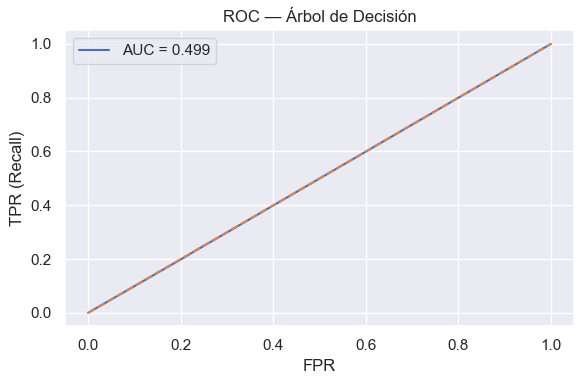

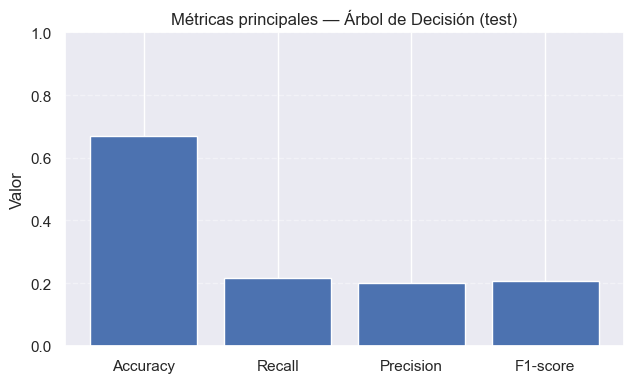

In [40]:
# === ROC/AUC (binario) + barras de métricas clave — ÁRBOL DE DECISIÓN ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# ROC/AUC si binario
if len(np.unique(y_test)) == 2 and scores_te is not None:
    pos_label = max(np.unique(y_test))
    fpr, tpr, thr = roc_curve(y_test, scores_te, pos_label=pos_label)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, scores_te):.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR (Recall)")
    plt.title("ROC — Árbol de Decisión")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Barras (Accuracy, Recall, Precision, F1) en test
avg = "binary" if len(np.unique(y_test))==2 else "weighted"
vals = {
    "Accuracy":  accuracy_score(y_test, y_pred_tree),
    "Recall":    recall_score(y_test, y_pred_tree, average=avg, zero_division=0),
    "Precision": precision_score(y_test, y_pred_tree, average=avg, zero_division=0),
    "F1-score":  f1_score(y_test, y_pred_tree, average=avg, zero_division=0),
}
plt.figure(figsize=(6.5,4))
plt.bar(list(vals.keys()), list(vals.values()))
plt.ylim(0,1)
plt.title("Métricas principales — Árbol de Decisión (test)")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


ROC -- Arbol de decisciones

La figura muestra la curva ROC del modelo de Árbol de Decisiones aplicado a la variable Outcome, evaluando si un individuo es diagnosticado con diabetes o no, utilizando el conjunto de prueba. La curva es casi diagonal, con un AUC de 0,499, lo que indica un desempeño prácticamente equivalente al azar y sugiere que las probabilidades predichas por el modelo ofrecen poca o ninguna separación entre las clases. Esta situación ocurre cuando las probabilidades derivadas de las hojas del árbol están mal calibradas o no son distintivas, lo que puede suceder si el árbol se sobreajusta o infraajusta, especialmente cuando muchas hojas contienen muestras mixtas de clases. En este conjunto de datos, el solapamiento de características entre las clases y el desequilibrio existente reducen aún más la capacidad del modelo para generar predicciones significativas. Como consecuencia, el umbral del modelo no se puede ajustar eficazmente, y se requiere la aplicación de estrategias como ingeniería de características, muestreo equilibrado o métodos de conjunto que promedien múltiples árboles para estabilizar las estimaciones de probabilidad. Finalmente, un AUC cercano a 0,5 refleja que, aunque el árbol pueda clasificar razonablemente la clase mayoritaria, no logra aprender una separación significativa de las clases, y los árboles de decisión por sí solos resultan inestables y sensibles al ruido, especialmente en presencia de variables correlacionadas o no informativas.

Metricas principales -- Arbol de decisciones

El gráfico de barras resume las principales métricas de rendimiento del modelo de Árbol de Decisiones aplicado a la variable Outcome, evaluando si un individuo es diagnosticado con diabetes o no, utilizando el conjunto de prueba. El modelo alcanzó una precisión general de 0,6685, mientras que las métricas correspondientes a la clase minoritaria muestran valores bajos: recall = 0,2163, precisión = 0,1989 y F1-score = 0,2072. Esto refleja que, aunque el modelo clasifica correctamente la clase mayoritaria la mayor parte del tiempo, falla al identificar los casos de diabetes, lo que evidencia un desempeño débil para la clase minoritaria. Esta limitación se debe a que el árbol de decisión captura principalmente los patrones dominantes de la clase mayoritaria y no generaliza adecuadamente el comportamiento de la minoría, posiblemente como resultado del desequilibrio de clases, poda insuficiente o divisiones dominadas por etiquetas frecuentes. La baja puntuación F1 indica un pobre equilibrio entre precisión y recuperación, ya que el modelo rara vez identifica correctamente los positivos y genera falsos positivos cuando lo hace. Para mejorar el desempeño en predicciones futuras, se sugiere reentrenar el modelo utilizando pesos de clase equilibrados, aplicar técnicas de remuestreo o probar enfoques alternativos. Cabe destacar que los árboles de decisión individuales son sensibles al sesgo de clases y al ruido; sin regularización adecuada, pueden memorizar patrones del conjunto de entrenamiento que no se generalizan al conjunto de prueba.

In [41]:
# === MÉTRICAS COMPLETAS — ÁRBOL DE DECISIÓN ===
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, matthews_corrcoef
)

# --- Configurar etiqueta positiva ---
classes = np.unique(y_test)
pos_label = 1 if 1 in classes else classes.max()

def binariza(y, pos):
    y = pd.Series(y).values
    return (y == pos).astype(int)

# --- Confusion matrix (multiclase y binario) ---
cm = confusion_matrix(y_test, y_pred_tree, labels=classes)
cm_df = pd.DataFrame(cm,
                     index=[f"Real {c}" for c in classes],
                     columns=[f"Pred {c}" for c in classes])
print("Matriz de confusión (Árbol de Decisión):")
display(cm_df)

# --- Métricas por clase y promedios (macro/weighted) ---
print("\nReporte de clasificación (Árbol de Decisión):")
rep_dict = classification_report(y_test, y_pred_tree, output_dict=True, zero_division=0)
display(pd.DataFrame(rep_dict).T.style.format("{:.4f}"))

# --- Métricas binarias principales para la clase positiva (pos_label) ---
y_true_bin = binariza(y_test, pos_label)
y_pred_bin = binariza(y_pred_tree, pos_label)

tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin, labels=[0,1]).ravel()
total = tn + fp + fn + tp

acc   = accuracy_score(y_true_bin, y_pred_bin)
error = 1 - acc
tpr   = tp / (tp + fn) if (tp + fn)>0 else 0.0     # Recall / Sensibilidad
fpr   = fp / (fp + tn) if (fp + tn)>0 else 0.0
tnr   = tn / (tn + fp) if (tn + fp)>0 else 0.0     # Especificidad
ppv   = precision_score(y_true_bin, y_pred_bin, zero_division=0)  # Precisión
npv   = tn / (tn + fn) if (tn + fn)>0 else 0.0
f1    = f1_score(y_true_bin, y_pred_bin, zero_division=0)
prev  = (tp + fn) / total if total>0 else 0.0
bacc  = (tpr + tnr) / 2
mcc   = matthews_corrcoef(y_true_bin, y_pred_bin) if total>0 else 0.0

# AUC con scores continuos si están disponibles (binario)
auc = None
if scores_te is not None:
    try:
        auc = roc_auc_score(y_true_bin, scores_te)
    except Exception:
        auc = None

# --- Tabla resumen ejecutiva ---
resumen = pd.DataFrame([
    ("Accuracy",                 acc),
    ("Error (1-Acc)",            error),
    ("TPR / Recall",             tpr),
    ("FPR",                      fpr),
    ("Especificidad (TNR)",      tnr),
    ("Precision (PPV)",          ppv),
    ("NPV",                      npv),
    ("F1-score",                 f1),
    ("Prevalencia P(Y=1)",       prev),
    ("Balanced Accuracy",        bacc),
    ("MCC",                      mcc),
    ("AUC (si hay scores)",      auc),
], columns=["Métrica", "Valor"])

print(f"\nClase positiva considerada: {pos_label}")
display(resumen.style.format({"Valor": lambda v: "—" if v is None else f"{v:.4f}"}).hide(axis="index"))

# --- Importancias de variables (feature importance) ---
try:
    feat_names = pipe_tree.named_steps["prep"].get_feature_names_out()
except Exception:
    feat_names = [f"feat_{i}" for i in range(pipe_tree.named_steps["prep"].transform(X_train).shape[1])]

importancias = pipe_tree.named_steps["clf"].feature_importances_
fi_df = pd.DataFrame({"feature": feat_names, "importance": importancias}) \
        .sort_values("importance", ascending=False)

display(fi_df.head(20))


Matriz de confusión (Árbol de Decisión):


,Pred 0,Pred 1
Real 0,27128,7572
Real 1,6813,1880



Reporte de clasificación (Árbol de Decisión):


,precision,recall,f1-score,support
0,0.7993,0.7818,0.7904,34700.0000
1,0.1989,0.2163,0.2072,8693.0000
accuracy,0.6685,0.6685,0.6685,0.6685
macro avg,0.4991,0.4990,0.4988,43393.0000
weighted avg,0.6790,0.6685,0.6736,43393.0000



Clase positiva considerada: 1


Métrica,Valor
Accuracy,0.6685
Error (1-Acc),0.3315
TPR / Recall,0.2163
FPR,0.2182
Especificidad (TNR),0.7818
Precision (PPV),0.1989
NPV,0.7993
F1-score,0.2072
Prevalencia P(Y=1),0.2003
Balanced Accuracy,0.4990


,feature,importance
8,num__StressLevel,0.463659
1,num__Glucose,0.050611
6,num__DiabetesPedigreeFunction,0.045107
5,num__BMI,0.043614
2,num__BloodPressure,0.034754
13,num__HighCarb,0.031047
7,num__Age,0.030342
12,num__Balanced,0.030129
3,num__SkinThickness,0.029851
14,num__LowCarb,0.029537


Resumen -- Arbol de decisciones

El modelo probablemente no ha convergido de manera correcta por varias razones: primero, el fuerte desequilibrio de clases (aproximadamente 80 % de no diabéticos frente a 20 % de diabéticos) hace que el árbol priorice la clase mayoritaria, resultando en un recall extremadamente bajo para la clase minoritaria y un AUC cercano a 0,5. Segundo, los árboles de decisión individuales son inherentemente inestables y sensibles al ruido o a características poco informativas; en este caso, variables correlacionadas o poco predictivas no contribuyen a mejorar la separación de clases. Tercero, la falta de poda adecuada o técnicas de regularización permite que el árbol memorice patrones específicos del entrenamiento sin aprender reglas generalizables, lo que provoca que las probabilidades de clase estén mal calibradas. Finalmente, la superposición de características entre diabéticos y no diabéticos (por ejemplo, glucosa, BMI o edad) dificulta aún más que el modelo encuentre fronteras de decisión claras. Todo esto explica por qué el AUC es casi aleatorio y por qué el desempeño sobre la clase minoritaria es tan deficiente. Para mejorar, sería necesario aplicar técnicas como muestreo balanceado, ponderación de clases, ensambles de árboles (Random Forest, Gradient Boosting) o ingeniería de características más robusta.

# Comparasion entre Modelos

Como se puede observar, todos los modelos evaluados mostraron un desempeño deficiente, incluso después de aplicar técnicas de balanceo como SMOTE y undersampling. No se observó ningún cambio significativo en la importancia de las variables, y la AUC permaneció cercana a 0,5 en todos los casos, lo que indica que los modelos prácticamente no tenían capacidad para discriminar entre individuos diagnosticados con diabetes (clase 1) y aquellos no diagnosticados (clase 0). En términos prácticos, su desempeño era equivalente a adivinar al azar.

Además, se evidenció un fuerte sesgo hacia la clase 0 en todos los modelos. Algunos modelos, como Naive Bayes y regresión logística, ignoraron por completo la clase 1, con cero verdaderos positivos y cero falsos positivos para los individuos con diabetes. Esto contrasta con la alta precisión reportada por estos modelos (0,7997), la cual es engañosamente inflada debido a la gran proporción de la clase mayoritaria. En otras palabras, estos modelos parecen precisos únicamente porque clasifican correctamente a los individuos no diabéticos, pero fallan totalmente al identificar los casos de diabetes, lo que demuestra que la precisión global no refleja el desempeño real del modelo.

Por esta razón, modelos con menor precisión general, como el Árbol de Decisiones (0,6685) y el Perceptrón (0,6214), resultan ser más confiables para evaluar el desempeño real, ya que reflejan mejor la dificultad del problema y muestran cierto intento de capturar patrones de ambas clases, aunque con limitaciones. Estos resultados también ponen de manifiesto que el desequilibrio de clases, la superposición de características entre individuos diabéticos y no diabéticos, y la limitada capacidad de los modelos para generalizar son factores clave que explican por qué incluso después del balanceo, la AUC no mejora y la discriminación de la clase minoritaria sigue siendo muy baja.